# [HW7] FBA QUANT - ASSET PRICING

Kim Na Young (dudskrla09@gmail.com)

---

# Assignment 1: Summarize this week's study 

Assignment 1's content has been incorporated into Assignment 3 in Markdown format, please use it as a reference.

---

# Assignment 2: Implement codes in the given papers

### Chap 3. Pulling a list of 10-K filings and documents informations
### 1. Web Scraping the SEC Query Page

**1) Parsing the XML Document of SEC Query Page**

In [149]:
# import our libraries
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd

# set column width in display
pd.set_option('display.max_colwidth', 30)

# Parameters for 10-K filing of Tesla, Inc.
cik = '1318605' # CIK number of Tesla
doc_type = '10-K' # filing type we want
date = '2023-07-30' # reference date
doc_num = 40 # the number of filings we search

# SEC EDGAR base URL
endpoint = r"https://www.sec.gov/cgi-bin/browse-edgar"

# Parameters for 10-K filing of Tesla, Inc.
params = {
    'action': 'getcompany',
    'CIK': '1318605', # CIK number of Tesla
    'type': '10-K', # filing type we want
    'dateb': '20230830', # reference date in 'yyyymmdd' format
    'owner': 'exclude',
    'start': '',
    'output': '', 
    'count': '40' # the number of filings we search
}

# User-agent for accession
headers = {"user-agent": "Mozilla/5.0"}

# Make HTTP request to the SEC EDGAR with the above parameters and parse the response
response = requests.get(url = endpoint, params = params)
soup = BeautifulSoup(response.content, 'html.parser')

# Modify parameters for XML output and make another HTTP request
params['output'] = 'atom'
response_xml = requests.get(url=endpoint, headers=headers, params=params)
soup_xml = BeautifulSoup(response_xml.content, "lxml")

# Check if requests were successful
if response.status_code == 200 and response_xml.status_code == 200: 
    print('Request Successful')

# Print the URLs for both HTML and XML versions
print(f"HyperLink (HTML): {response.url}")
print("-"*100)
print(f"HyperLink (XML): {response_xml.url}")

HyperLink (HTML): https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1318605&type=10-K&dateb=20230830&owner=exclude&start=&output=&count=40
----------------------------------------------------------------------------------------------------
HyperLink (XML): https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=1318605&type=10-K&dateb=20230830&owner=exclude&start=&output=atom&count=40


**2) Structure of XML file and Parsing the that**

In [150]:
# Parameters for 10-K filing of Tesla, Inc.
cik = '1318605' # CIK number of Tesla
ticker = 'tsla' # Ticker (Identifying symbol) of tesla
doc_type = '10-K' # filing type we want
doc_num = 40 # the number of filings we search
today = datetime.today().strftime("%Y%m%d")

# SEC EDGAR base URL
endpoint = r"https://www.sec.gov/cgi-bin/browse-edgar"

# Parameters for 10-K filing of Tesla, Inc.
params = {
    'action': 'getcompany',
    'CIK': ticker, # CIK number or Ticker of Tesla
    'type': doc_type, # filing type we want
    'dateb': today, # reference date in 'yyyymmdd' format
    'owner': 'exclude',
    'start': '',
    'output': 'atom', 
    'count': '40' # the number of filings we search
}

# User-agent for accession
headers = {"user-agent": "Mozilla/5.0"}

# Make HTTP request to the SEC EDGAR with the above parameters and parse the response
resp = requests.get(url = endpoint, headers=headers, params = params)
soup_xml = BeautifulSoup(resp.content, "lxml")

# Show the structure of XML file
for count, line in enumerate(soup_xml.prettify().split('\n')):
    
    if count > 120: break
    
    if len(line) > 80: line = line[:80] + "..."
    print(line)

<?xml version="1.0" encoding="ISO-8859-1" ?>
<html>
 <body>
  <feed xmlns="http://www.w3.org/2005/Atom">
   <author>
    <email>
     webmaster@sec.gov
    </email>
    <name>
     Webmaster
    </name>
   </author>
   <company-info>
    <addresses>
     <address type="mailing">
      <city>
       PALO ALTO
      </city>
      <state>
       CA
      </state>
      <street1>
       3500 DEER CREEK RD
      </street1>
      <zip>
       94304
      </zip>
     </address>
     <address type="business">
      <city>
       PALO ALTO
      </city>
      <phone>
       650-681-5000
      </phone>
      <state>
       CA
      </state>
      <street1>
       3500 DEER CREEK RD
      </street1>
      <zip>
       94304
      </zip>
     </address>
    </addresses>
    <assigned-sic>
     3711
    </assigned-sic>
    <assigned-sic-desc>
     MOTOR VEHICLES &amp;amp; PASSENGER CAR BODIES
    </assigned-sic-desc>
    <assigned-sic-href>
     https://www.sec.gov/cgi-bin/browse-edgar?action=getco

### 2. Find the hyperlink of XBRL files through EDGAR SEARCH PAGE

**1) What is the XBRL (eXtensible Business Reporting Language) Document?**

In [151]:
# find all the entry tags
entries = soup_xml.find_all("entry")
company_name = soup_xml.find("conformed-name").text

data_list = []

# Loop through each entry
for entry in entries:
    
    # grab filing type
    category_info = entry.find("category")
    filing_type = category_info["term"]
    
    # grab only 10-K
    if filing_type == "10-K":
    
        # find the accession number so we can create a key value
        accs_no = entry.find("accession-number").text
    
        # find url linking details of 10-K filing
        details_url = entry.find("filing-href").text
        
        # fetch datetime from filing details
        resp = requests.get(details_url, headers=headers)
        soup = BeautifulSoup(resp.content, 'html.parser')
        
        # find fiscal year and datetime in which the 10-K filing disclosed
        dt_info = soup.find_all("div", {"class":"info"})
        filing_dt = dt_info[1].text
        fs_year = dt_info[3].text
        
        # find the url of XBRL 
        endpoint = "https://www.sec.gov"
        row_with_10k = soup.find('td', text='10-K').find_parent('tr')
        href_10k = row_with_10k.find('a')['href']
        xbrl_url = endpoint + href_10k
        
        # make url for archive of 10-K filings
        archive_url = f"https://www.sec.gov/Archives/edgar/data/{cik}/{accs_no.replace('-','')}"
        
        # Append the data to the list as a dictionary
        data_list.append({
            "fiscal_year": int(fs_year[:4]),
            "filing_type": filing_type,
            "accs_no": accs_no,
            "filing_date": filing_dt,
            "details": details_url,
            "xbrl_doc": xbrl_url,
            "archive": archive_url
        })

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

# Organize DataFrame
df["filing_date"] = pd.to_datetime(df["filing_date"])
df.set_index("fiscal_year", inplace=True)

display(df)

,filing_type,accs_no,filing_date,details,xbrl_doc,archive
fiscal_year,,,,,,
2022,10-K,0000950170-23-001409,2023-01-30 21:29:15,https://www.sec.gov/Archiv...,https://www.sec.gov/ix?doc...,https://www.sec.gov/Archiv...
2021,10-K,0000950170-22-000796,2022-02-04 20:11:27,https://www.sec.gov/Archiv...,https://www.sec.gov/ix?doc...,https://www.sec.gov/Archiv...
2020,10-K,0001564590-21-004599,2021-02-08 07:27:23,https://www.sec.gov/Archiv...,https://www.sec.gov/ix?doc...,https://www.sec.gov/Archiv...
2019,10-K,0001564590-20-004475,2020-02-13 07:12:18,https://www.sec.gov/Archiv...,https://www.sec.gov/ix?doc...,https://www.sec.gov/Archiv...
2018,10-K,0001564590-19-003165,2019-02-19 06:10:16,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...
2017,10-K,0001564590-18-002956,2018-02-23 06:07:43,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...
2016,10-K,0001564590-17-003118,2017-03-01 16:54:21,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...
2015,10-K,0001564590-16-013195,2016-02-24 16:17:56,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...
2014,10-K,0001564590-15-001031,2015-02-26 17:13:26,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...


In [152]:
# Print header: company name
print("Company Name:", company_name)
print("CIK number:", cik)
print("Ticker:", ticker.upper())
print("-"*100)

# Print the last three 10-K filings from the dataframe 
for index, row in df.iterrows():
    print("Fiscal Year", index)
    print("Accession Number:", row['accs_no'])
    print("Filing Type:", row['filing_type'])
    print("Filing Datetime:", row['filing_date'])
    print("Details:", row['details'])
    print("XBRL Document:", row['xbrl_doc'])
    print("Archive:", row['archive'])
    print("-" * 100)

Company Name: Tesla, Inc.
CIK number: 1318605
Ticker: TSLA
----------------------------------------------------------------------------------------------------
Fiscal Year 2022
Accession Number: 0000950170-23-001409
Filing Type: 10-K
Filing Datetime: 2023-01-30 21:29:15
Details: https://www.sec.gov/Archives/edgar/data/1318605/000095017023001409/0000950170-23-001409-index.htm
XBRL Document: https://www.sec.gov/ix?doc=/Archives/edgar/data/1318605/000095017023001409/tsla-20221231.htm
Archive: https://www.sec.gov/Archives/edgar/data/1318605/000095017023001409
----------------------------------------------------------------------------------------------------
Fiscal Year 2021
Accession Number: 0000950170-22-000796
Filing Type: 10-K
Filing Datetime: 2022-02-04 20:11:27
Details: https://www.sec.gov/Archives/edgar/data/1318605/000095017022000796/0000950170-22-000796-index.htm
XBRL Document: https://www.sec.gov/ix?doc=/Archives/edgar/data/1318605/000095017022000796/tsla-20211231.htm
Archive: ht

### Chap 4. Extracting financial statements from SEC Filings 

**1) Wrap the code you completed in Chap 3 as a function**

In [153]:
# !pip install sec_cik_mapper # install sec-cik-mapper to find cik number from ticker
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from sec_cik_mapper import StockMapper
from tqdm import tqdm
import json

# set column width in display
pd.set_option('display.max_colwidth', 30)

In [154]:
def parse_filing_info(ticker, doc_type="10-k", date=None, doc_num=40):
    
    mapper = StockMapper()
    cik = mapper.ticker_to_cik[ticker.upper()]
    
    if date is None:
        date = datetime.today().strftime("%Y%m%d")
    else:
        date = date.replace('-','')

    # SEC EDGAR base URL
    endpoint = r"https://www.sec.gov/cgi-bin/browse-edgar"

    # Parameters for 10-K filing of Tesla, Inc.
    params = {
        'action': 'getcompany',
        'CIK': ticker, # CIK number or Ticker of Tesla
        'type': doc_type, # filing type we want
        'dateb': date, # reference date in 'yyyymmdd' format
        'owner': 'exclude',
        'start': '',
        'output': 'atom', 
        'count': '40' # the number of filings we search
    }

    # User-agent for accession
    headers = {"user-agent": "Mozilla/5.0"}

    # Make HTTP request to the SEC EDGAR with the above parameters and parse the response
    resp = requests.get(url = endpoint, headers=headers, params = params)
    soup_xml = BeautifulSoup(resp.content, "lxml")

    # find all the entry tags
    entries = soup_xml.find_all("entry")
    company_name = soup_xml.find("conformed-name").text

    data_list = []

    # Loop through each entry
    for entry in tqdm(entries):

        # grab filing type
        category_info = entry.find("category")
        filing_type = category_info["term"]

        # grab only 10-K
        if filing_type == "10-K":

            # find the accession number so we can create a key value
            accs_no = entry.find("accession-number").text

            # find url linking details of 10-K filing
            details_url = entry.find("filing-href").text

            # fetch datetime from filing details
            resp = requests.get(details_url, headers=headers)
            soup = BeautifulSoup(resp.content, 'html.parser')

            # find fiscal year and datetime in which the 10-K filing disclosed
            dt_info = soup.find_all("div", {"class":"info"})
            filing_dt = dt_info[1].text
            fs_year = dt_info[3].text

            # make url for XBRL document of 10-K filings
            endpoint = "https://www.sec.gov/Archives/edgar/data"
            ref_year = int(fs_year[:4])
            filing_tag = filing_type.replace('-','').lower()
            year_tag = fs_year.replace("-","")
            
            xbrl_xml_url = f"{endpoint}/{cik}/{accs_no.replace('-','')}/{ticker}-{year_tag}.xml"
            resp = requests.get(xbrl_xml_url, headers=headers)

            # Note: the URL structure has been changed since the file format has changed from XBRL to iXBRL.
            # 404 Forbidden means that url structure is invalid
            if resp.status_code == 404:
                xbrl_xml_url = xbrl_xml_url.replace(".xml", "_htm.xml")
                resp = requests.get(xbrl_xml_url, headers=headers)
            
            if resp.status_code == 404:
                xbrl_xml_url = xbrl_xml_url.replace(f"{year_tag}", f"{filing_tag}_{year_tag}")
                resp = requests.get(xbrl_xml_url, headers=headers)
                
            if resp.status_code == 404:
                xbrl_xml_url = None
            
            # make url for archive of 10-K filings
            archive_url = f"https://www.sec.gov/Archives/edgar/data/{cik}/{accs_no.replace('-','')}"

            # Append the data to the list as a dictionary
            data_list.append({
                "fiscal_year": int(fs_year[:4]),
                "filing_type": filing_type,
                "accs_no": accs_no,
                "filing_date": filing_dt,
                "Details": details_url,
                "XBRL_XML": xbrl_xml_url,
                "archive": archive_url
            })

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data_list)

    # Organize DataFrame
    df["filing_date"] = pd.to_datetime(df["filing_date"])
    df.set_index("fiscal_year", inplace=True)

    return df

In [155]:
tsla_10k_info = parse_filing_info('tsla')
display(tsla_10k_info)

100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


,filing_type,accs_no,filing_date,Details,XBRL_XML,archive
fiscal_year,,,,,,
2022,10-K,0000950170-23-001409,2023-01-30 21:29:15,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...
2021,10-K,0000950170-22-000796,2022-02-04 20:11:27,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...
2020,10-K,0001564590-21-004599,2021-02-08 07:27:23,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...
2019,10-K,0001564590-20-004475,2020-02-13 07:12:18,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...
2018,10-K,0001564590-19-003165,2019-02-19 06:10:16,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...
2017,10-K,0001564590-18-002956,2018-02-23 06:07:43,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...
2016,10-K,0001564590-17-003118,2017-03-01 16:54:21,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...
2015,10-K,0001564590-16-013195,2016-02-24 16:17:56,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...
2014,10-K,0001564590-15-001031,2015-02-26 17:13:26,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...,https://www.sec.gov/Archiv...


**2) Extracting Financial Statements from SEC Filings - XBRL-To-JSON**

In [156]:
# !pip install sec-api # install the SEC API Python package

# get your free API key at https://sec-api.io
# find your free API key at https://sec-api.io/profile
apikey = "Insert_Your_API_key"
apikey = "912631791bbf2cd6277f57dfdee594c9511133b8be5d63a9e73b162cb82f654a"

# Insert a year when you want to find information
year = 2022

# 10-K XBRL filing URL of TESLA on a year you selected
filing_xml_url = tsla_10k_info.loc[year, "XBRL_XML"]
print("XBRL Document:", filing_xml_url)

# XBRL-to-JSON converter API endpoint
xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"

final_url = xbrl_converter_api_endpoint + "?htm-url=" + filing_xml_url + "&token=" + apikey

# make request to the API
response = requests.get(final_url)

# load JSON into memory
xbrl_json = json.loads(response.text)

# income statement example
print(json.dumps(xbrl_json['StatementsOfIncome']['RevenueFromContractWithCustomerExcludingAssessedTax'][0:2], indent=1))

XBRL Document: https://www.sec.gov/Archives/edgar/data/0001318605/000095017023001409/tsla-20221231_htm.xml
[
 {
  "decimals": "-6",
  "unitRef": "U_USD",
  "period": {
   "startDate": "2022-01-01",
   "endDate": "2022-12-31"
  },
  "segment": {
   "dimension": "srt:ProductOrServiceAxis",
   "value": "tsla:EnergyGenerationAndStorageMember"
  },
  "value": "3909000000"
 },
 {
  "decimals": "-6",
  "unitRef": "U_USD",
  "period": {
   "startDate": "2021-01-01",
   "endDate": "2021-12-31"
  },
  "segment": {
   "dimension": "srt:ProductOrServiceAxis",
   "value": "tsla:EnergyGenerationAndStorageMember"
  },
  "value": "2789000000"
 }
]


In [157]:
def get_income_statement(xbrl_json):
    income_statement_store = {}

    # iterate over each US GAAP item in the income statement
    for usGaapItem in xbrl_json['StatementsOfIncome']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfIncome'][usGaapItem]:
            # only consider items without segment. not required for our analysis.
            if 'segment' not in fact:
                index = fact['period']['startDate'] + '-' + fact['period']['endDate']
                # ensure no index duplicates are created
                if index not in indicies:
                    values.append(fact['value'])
                    indicies.append(index)

        # Explicitly specify dtype when creating the Series
        if values:
            dtype = type(values[0])
        else:
            dtype = 'object'
        income_statement_store[usGaapItem] = pd.Series(values, index=indicies, dtype=dtype)

    income_statement = pd.DataFrame(income_statement_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date range
    return income_statement.T

income_statement = get_income_statement(xbrl_json)
income_statement.columns = [x[-10:] for x in income_statement.columns]
income_statement = income_statement.loc[:, [f"{year}-12-31", f"{year-1}-12-31"]]
income_statement
display(income_statement)

,2022-12-31,2021-12-31
EarningsPerShareBasic,4.02,1.87
WeightedAverageNumberOfSharesOutstandingBasic,3130000000,2959000000
ResearchAndDevelopmentExpense,3075000000,2593000000
AutomotiveSalesRevenue,NaN,NaN
AutomotiveSales,NaN,NaN
EarningsPerShareDiluted,3.62,1.63
WeightedAverageNumberOfDilutedSharesOutstanding,3475000000,3386000000
SellingGeneralAndAdministrativeExpense,3946000000,4517000000
AutomotiveRegulatoryCredits,NaN,NaN
DirectCostsOfLeasedAndRentedPropertyOrEquipment,NaN,NaN


In [158]:
def get_balance_sheet(xbrl_json):
    balance_sheet_store = {}

    for usGaapItem in xbrl_json['BalanceSheets']:
        values = []
        indicies = []

        for fact in xbrl_json['BalanceSheets'][usGaapItem]:
            # only consider items without segment.
            if 'segment' not in fact:
                index = fact['period']['instant']

                # avoid duplicate indicies with same values
                if index in indicies:
                    continue

                # add 0 if value is nil
                if "value" not in fact:
                    values.append(0)
                else:
                    values.append(fact['value'])

                indicies.append(index)
        
        # Explicitly specify dtype when creating the Series
        if values:
            dtype = type(values[0])
        else:
            dtype = 'object'
        balance_sheet_store[usGaapItem] = pd.Series(values, index=indicies, dtype=dtype)

    balance_sheet = pd.DataFrame(balance_sheet_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date instant
    return balance_sheet.T

balance_sheet = get_balance_sheet(xbrl_json)
balance_sheet = balance_sheet.loc[:, [f"{year}-12-31", f"{year-1}-12-31"]]
display(balance_sheet)

,2022-12-31,2021-12-31
PreferredStockValue,0,0
CashAndCashEquivalentsAtCarryingValue,16253000000,17576000000
AccountsPayableCurrent,15255000000,10025000000
MinorityInterest,785000000,826000000
LongTermDebtAndFinanceLeasesNoncurrent,1597000000,5245000000
CommonStockValue,3000000,3000000
DeferredCostsLeasingNetNoncurrent,NaN,NaN
ShortTermInvestments,5932000000,131000000
AccruedAndOtherCurrentLiabilities,7142000000,5719000000
CommitmentsAndContingencies,0.0,0.0


In [159]:
def get_cash_flow_statement(xbrl_json):
    cash_flows_store = {}

    for usGaapItem in xbrl_json['StatementsOfCashFlows']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfCashFlows'][usGaapItem]:
            # only consider items without segment.
            if 'segment' not in fact:
                # check if date instant or date range is present
                if "instant" in fact['period']:
                    index = fact['period']['instant']
                else:
                    index = fact['period']['startDate'] + '-' + fact['period']['endDate']

                # avoid duplicate indicies with same values
                if index in indicies:
                    continue

                if "value" not in fact:
                    values.append(0)
                else:
                    values.append(fact['value'])

                indicies.append(index)
        
        # Explicitly specify dtype when creating the Series
        if values:
            dtype = type(values[0])
        else:
            dtype = 'object'
        cash_flows_store[usGaapItem] = pd.Series(values, index=indicies, dtype=dtype)

    cash_flows = pd.DataFrame(cash_flows_store)
    return cash_flows.T

cash_flows = get_cash_flow_statement(xbrl_json)
cash_flows.columns = [x[-10:] if len(x) > 10 else "deleted" for x in cash_flows.columns]
cash_flows = cash_flows.loc[:, [f"{year}-12-31", f"{year-1}-12-31"]]
display(cash_flows)

,2022-12-31,2021-12-31
ProceedsFromIssuanceOfCommonStock,0,0
InterestPaidNet,152000000,266000000
ProfitLoss,12587000000,5644000000
PaymentsToAcquirePropertyPlantAndEquipment,7158000000,6482000000
DepreciationAmortizationAndImpairment,3747000000,2911000000
IncreaseDecreaseInAccountsReceivable,1124000000,130000000
NoncashOrPartNoncashAcquisitionValueOfAssetsAcquired1,2148000000,2251000000
ProceedsFromIssuanceOfDebt,0,8883000000
IncomeTaxesPaid,1203000000,561000000
PaymentsForSolarEnergySystemsNetOfSales,5000000,32000000


**3) (Optional) Parsing the XBRL document and Completing omitted values**

In [160]:
year = 2022

filing_xml_url = tsla_10k_info.loc[year, "XBRL_XML"]
headers = {"User-agent":"Mozilla/5.0"}

resp = requests.get(filing_xml_url, headers=headers)
xml_content = resp.text

# save the xml content to a xml file
with open(f"tsla_{year}.xml", "w", encoding="utf-8") as f:
    f.write(xml_content)

# load the file and parse with parser.lxml
with open("tsla_2022.xml", "r") as file:
    xml = BeautifulSoup(file, "lxml")

In [161]:
import re
from tqdm import tqdm 

all_tags = [tag.name for tag in xml.find_all(True)]

result = {}
for tag in tqdm(all_tags):
    text = xml.find(tag).text

    if ("dei" in tag) or ("us-gaap" in tag) or ("tsla" in tag):
        
        cleaned_text = re.sub(r'<.*?>', '', text)
        cleaned_text = re.sub(r'(\n\s*)+', '\n    ', cleaned_text)
        cleaned_text = re.sub(r'(\xa0)+', '', cleaned_text)

        tag_key = tag.replace("dei:","").replace("us-gaap:","").replace("tsla:","")
        
        try:
            result[tag_key] = int(cleaned_text)
        except:
            result[tag_key] = cleaned_text

            
temp = []
with open(f'tsla_{year}_xbrl.txt', 'w', encoding='utf-8') as file:
    
    for tag, content in result.items():
   
        temp.append({"tag":tag, "content":content})

        file.write("tag: " + tag + '\n')
        file.write("content: " + cleaned_text + '\n')
        file.write("="*100 + '\n')
            
df = pd.DataFrame(temp)
df.to_csv("tsla_2022_xbrl.csv")

 52%|█████▏    | 2745/5294 [00:00<00:00, 14339.13it/s]

100%|██████████| 5294/5294 [00:46<00:00, 112.94it/s]  


In [162]:
# print a fraction of XBRL tag-content for example
for count, (k, v) in enumerate(result.items()):
    
    if count > 200:
        print(k)
        print(v)
        print("-" * 100)

    if count > 210:
        break

contractwithcustomerliabilityrevenuerecognizedoutofpriorperiodbalance
472000000
----------------------------------------------------------------------------------------------------
contractwithcustomerassetandliabilityrevenuerecognizedinnextrollingtwelvemonths
639000000
----------------------------------------------------------------------------------------------------
notesreceivablenet
128000000
----------------------------------------------------------------------------------------------------
revenueduetochangesinregulation
288000000
----------------------------------------------------------------------------------------------------
directleaseterm
P48M
----------------------------------------------------------------------------------------------------
lessorsalestypeleasetermofcontract1
P72M
----------------------------------------------------------------------------------------------------
salestypeleaserevenue
683000000
-----------------------------------------------------------

In [163]:
# Fill omitted values
temp = []
for idx in income_statement.index:
    
    if pd.isnull(income_statement.loc[idx, f"{year}-12-31"]):
        
        item = idx.lower().replace(" ","")
        value = result[item]
        
        income_statement.loc[idx, f"{year}-12-31"] = value

# Rearrange income statement in the conventional order
order = [
    'Revenues',
    'AutomotiveSalesRevenue',
    'AutomotiveSales',
    'AutomotiveRegulatoryCredits',
    'CostOfGoodsAndServicesSold',
    'AutomotiveCostOfRevenues',
    'GrossProfit',
    'OperatingExpenses',
    'ResearchAndDevelopmentExpense',
    'SellingGeneralAndAdministrativeExpense',
    'RestructuringAndOtherExpenses',
    'OperatingIncomeLoss',
    'OtherNonoperatingIncomeExpense',
    'InvestmentIncomeInterest',
    'InterestExpense',
    'IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest',
    'IncomeTaxExpenseBenefit',
    'ProfitLoss',
    'NetIncomeLossAttributableToNoncontrollingInterest',
    'NetIncomeLoss',
    'EarningsPerShareBasic',
    'EarningsPerShareDiluted',
    'WeightedAverageNumberOfSharesOutstandingBasic',
    'WeightedAverageNumberOfDilutedSharesOutstanding']

income_statement = income_statement.reindex(order)
display(income_statement)

,2022-12-31,2021-12-31
Revenues,81462000000,53823000000
AutomotiveSalesRevenue,67210000000,NaN
AutomotiveSales,49599000000,NaN
AutomotiveRegulatoryCredits,1776000000,NaN
CostOfGoodsAndServicesSold,3621000000,NaN
AutomotiveCostOfRevenues,51108000000,NaN
GrossProfit,20853000000,13606000000
OperatingExpenses,7197000000,7083000000
ResearchAndDevelopmentExpense,3075000000,2593000000
SellingGeneralAndAdministrativeExpense,3946000000,4517000000


In [164]:
# Fill omitted values
temp = []
for idx in balance_sheet.index:
    
    if pd.isnull(balance_sheet.loc[idx, f"{year}-12-31"]):
        
        item = idx.lower().replace(" ","")
        value = result[item]
        
        balance_sheet.loc[idx, f"{year}-12-31"] = value
        
# Rearrange balance sheet in the conventional order
order = [
    'Assets',
    'AssetsCurrent',
    'CashAndCashEquivalentsAtCarryingValue',
    'ShortTermInvestments',
    'AccountsReceivableNetCurrent',
    'InventoryNet',
    'PrepaidExpenseAndOtherAssetsCurrent',
    'CustomerDepositsLiabilitiesCurrent',
    'PropertyPlantAndEquipmentNet',
    'IntangibleAssetsNetExcludingGoodwill',
    'Goodwill',
    'DigitalAssetsNetNonCurrent',
    'OtherAssetsNoncurrent',
    'OperatingLeaseRightOfUseAsset',
    'DeferredCostsLeasingNetNoncurrent',
    'LiabilitiesAndStockholdersEquity',
    'Liabilities',
    'LiabilitiesCurrent',
    'AccountsPayableCurrent',
    'AccruedAndOtherCurrentLiabilities',
    'ContractWithCustomerLiabilityCurrent',
    'LongTermDebtAndFinanceLeasesCurrent',
    'LongTermDebtAndFinanceLeasesNoncurrent',
    'OtherLiabilitiesNoncurrent',
    'ContractWithCustomerLiabilityNoncurrent',
    'StockholdersEquity',
    'CommonStockValue',
    'AdditionalPaidInCapitalCommonStock',
    'RetainedEarningsAccumulatedDeficit',
    'AccumulatedOtherComprehensiveIncomeLossNetOfTax',
    'MinorityInterest',
    'RedeemableNoncontrollingInterestEquityCarryingAmount',
    'CommitmentsAndContingencies',
    'PreferredStockValue']

balance_sheet = balance_sheet.reindex(order)
display(balance_sheet)

,2022-12-31,2021-12-31
Assets,82338000000,62131000000
AssetsCurrent,40917000000,27100000000
CashAndCashEquivalentsAtCarryingValue,16253000000,17576000000
ShortTermInvestments,5932000000,131000000
AccountsReceivableNetCurrent,2952000000,1913000000
InventoryNet,12839000000,5757000000
PrepaidExpenseAndOtherAssetsCurrent,2941000000,1723000000
CustomerDepositsLiabilitiesCurrent,1063000000,925000000
PropertyPlantAndEquipmentNet,23548000000,18884000000
IntangibleAssetsNetExcludingGoodwill,215000000,257000000


---

# Assignment 3: Implement DCF Valuation of Tesla Inc. 

DCF valuation 설명
- https://exhibitlove.tistory.com/294

**(0) [Input] The input fata we will work with**          
beginning with the following data frames, converting the Excel file from Section 11. Valuation of Tesla of the lecture.

In [165]:
import pandas as pd

PnL_source = {
    "Year": ["2014 Act", "2015 Act", "2016 Act", "2017 Act", "2018 H1 Act"],
    "Automotive revenues": [3007012, 3740973, 6350766, 9641300, 6092998],
    "Energy generation and storage": [4208, 14477, 181394, 1116266, 784430],
    "Services and other": [187136, 290575, 467972, 1001185, 533554],
    "Total revenues": [3198356, 4046025, 7000132, 11758751, 7410982],
    "Automotive cost of revenues": [-2145749, -2823302, -4750081, -7432704, -4862547],
    "Energy generation and storage cost of revenues": [-4005, -12287, -178332, -874538, -705636],
    "Services and other cost of revenues": [-166931, -286933, -472462, -1229022, -767343],
    "Gross profit": [881671, 923503, 1599257, 2222487, 1075456],
    "Research and development": [-464700, -717900, -834408, -1378073, -753225],
    "Selling, general and administrative": [-603660, -922232, -1432189, -2476500, -1437163],
    "Restructuring and other": [0, 0, 0, 0, -103434], # FIX HERE
    "EBIT": [-186689, -716629, -667340, -1632086, -1218366],
    "Interest income": [1126, 1508, 8530, 19686, 10278],
    "Interest expense": [-100886, -118851, -198810, -471259, -313128],
    "Other income (expense), net": [1813, -41652, 111272, -125373, 13195],
    "EBT": [-284636, -875624, -746348, -2209032, -1508021],
    "Provision for income taxes": [-9404, -13039, -26698, -31546, -19312],
    "Net loss incl. minority interests": [-294040, -888663, -773046, -2240578, -1527333],
    "Minority interests": [0, 0, 98132, 279178, 100243],
    "Net loss": [-294040, -888663, -674914, -1961400, -1427090]
}

BS_source = {
    "Date": ["31 Dec 2014", "31 Dec 2015", "31 Dec 2016", "31 Dec 2017", "30 Jun 2018"],
    "Cash and cash equivalents": [1905713, 1196908, 3393216, 3367914, 2236424],
    "Restricted cash and marketable securities": [17947, 22628, 105519, 155323, 146822],
    "Accounts receivable, net": [226604, 168965, 499142, 515381, 569874],
    "Inventory": [953675, 1277838, 2067454, 2263537, 3324643],
    "Prepaid expenses and other current assets": [76134, 115667, 194465, 268365, 422034],
    "Total current assets": [3180073, 2782006, 6259796, 6570520, 6699797],
    "Operating lease vehicles, net": [766744, 1791403, 3134080, 4116604, 2282047],
    "Solar energy systems, leased and to be leased, net": [0, 0, 5919880, 6347490, 6340031],
    "Property, plant and equipment, net": [1829267, 3403334, 5982957, 10027522, 10969348],
    "Intangible assets, net": [0, 12816, 376145, 361502, 364690],
    "Other portion": [0, 0, 506302, 516889, 434841],
    "Restricted cash, net of current portion": [11374, 31522, 268165, 441722, 399992],
    "Other assets": [43209, 46858, 216751, 273123, 419254],
    "Total assets": [5830667, 8067939, 22664076, 28655372, 27910000],
    "Accounts payable": [777946, 916148, 1860341, 2390250, 3030493],
    "Accrued liabilities": [268883, 422798, 1210028, 1731366, 1814979],
    "Deferred revenue": [191651, 423961, 763126, 1015253, 576321],
    "Resale value guarantees": [0, 136831, 179504, 787333, 674255],
    "Customer deposits": [257587, 283370, 663859, 853919, 942129],
    "Current portion of long-term debt and capital leases": [611099, 627927, 984211, 796549, 2103185],
    "Current portion of solar bonds issued to related parties": [0, 0, 165936, 100000, 0],
    "Total current liabilities": [2107166, 2811035, 5827005, 7674670, 9141362],
    "Long-term debt and capital leases, net of current portion": [1818785, 2021093, 5860049, 9415700, 9513390],
    "Other liabilities": [993006, 2152107, 5438936, 6330414, 3988135],
    "Total liabilities": [4918957, 6984235, 17125990, 23420784, 22642887],
    "Total stockholders' equity": [911710, 1083704, 4752911, 4237242, 4445957],
    "Noncontrolling interests in subsidiaries": [0, 0, 785175, 997346, 821156],
    "Total liabilities and equity": [5830667, 8067939, 22664076, 28655372, 27910000],
    "DSO" : [25.51, 15.03, 25.67, 15.78, 13.84],
    "DIO" : [148.20, 147.32, 137.81, 85.45, 94.46],
    "DPO" : [120.89, 105.62, 124.00, 90.23, 86.10],
    "Net Trading Cycle" : [52.81, 56.73, 39.47, 11.00, 22.20]
}

PnL = pd.DataFrame(PnL_source)
BS = pd.DataFrame(BS_source)

**(1) [Input] Organizing external inputs in a 'Drivers' sheet**

![Alt text](image-2.png)

- Bond Yield → for cost of debt
- Corporate tax rate, Expected inflation → estimated value 
- Company beta → search value in Yahoo finance 

In [2]:
company_name = "Tesla"
currency = "USD"
domestic_country = "United States"
ten_year_treasury_yield = 3.07 / 100 
market_risk_premium_US = 5 / 100
company_beta = 0.78
tesla_share_price = 307.8
bond_yield = 7.50 / 100
corporate_tax_rate = 30 / 100
expected_inflation = 2 / 100

In [3]:
list_model_name = ["Tesla Model 3", \
                   "Tesla Model S and X", \
                    "Tesla Model Y", \
                    "Tesla Roadster 2", \
                    "Tesla Pickup", \
                    "Tesla Semi"]

## **0. Intro**

**Emoticon Sign**          
- 🔍 : Reference site 
- 💭 : Assumption
- ✏️ : formula

## **1. Income statement items**

### **1) Automotive**

**📑 [Excel sheet: Deliveries]**



🔍 **Reference**
- (Purpose) for calculating **revenue**
- (Information)
    - (1) **the number of deliveries** forecasted  
    - (2) **the average price** of goods expected to be sold
- (Site) 
    - (1) https://cleantechnica.com/2017/12/25/tesla-vehicle-revenue-2022-73-7-billion/
    - (2) Tesla's Guidance



**(2) [Forecast] Forecasting Tesla's expected deliveries**

- ✏️ **y-o-y growth rate** (year on year growth rate) 
	$$ Growth \; rate = \frac{Current \; year \; deliveries \; numbers}{Prior \; year \; deliveries \; numbers} - 1 (\%) $$ 
- ✏️ **Deliveries numbers**
$$ Deliveries \; numbers = Privious \; period \; deliveries * (1+Growth \; rate) $$ 
- 💭 **Growth rate**
	- Assumed growth after introduction:	
		- 2 years (during 2 years) : 10%
		- 4 years (during 2 years) : 5%
		- onwards : 2%
	- Tesla Model Y, Pickup, Semi's growth rate is the same of Tesla Model 3
	- Tesla Model S and X's growth rate is 2% after 2018


In [4]:
# Initialize deliveries numbers
dict_deliveries_numbers_automotive = dict()
dict_deliveries_numbers_automotive["Tesla Model 3"] = [0, 0, 0, 1764, 130620, 260000, 416000]          # 2014 ~ 2020
dict_deliveries_numbers_automotive["Tesla Model S and X"] = [33600, 50580, 76230, 101312, 100000]      # 2014 ~ 2018
dict_deliveries_numbers_automotive["Tesla Model Y"] = [0, 0, 0, 0, 0, 1764]                            # 2014 ~ 2019
dict_deliveries_numbers_automotive["Tesla Roadster 2"] = [0, 0, 0, 0, 0, 0, 500]                 # 2014 ~ 2019
dict_deliveries_numbers_automotive["Tesla Pickup"] = [0, 0, 0, 0, 0, 250]                     # 2014 ~ 2019
dict_deliveries_numbers_automotive["Tesla Semi"] = [0, 0, 0, 0, 0, 250]                       # 2014 ~ 2019

In [5]:
# Initialize growth rate 
dict_growth_rate_automotive = dict()
list_existed_model = ["Tesla Model 3", "Tesla Model S and X"]
for model_name in list_existed_model:
    list_deliveries_number = dict_deliveries_numbers_automotive[model_name]
    dict_growth_rate_automotive[model_name] = [(list_deliveries_number[i]/list_deliveries_number[i-1])-1 \
                                        if list_deliveries_number[i-1] != 0 else 0 \
                                        for i in range(1, len(list_deliveries_number))]
    dict_growth_rate_automotive[model_name].insert(0, 0) # 2014 growth rate : 0 # if 2014 growth rate exists, then change this code 

# 1) Existed model 
dict_growth_rate_automotive["Tesla Model 3"] += [0.10, 0.10, 0.05, 0.05]
for model_name in list_existed_model:
    dict_growth_rate_automotive[model_name] += [0.02] * (15 - len(dict_growth_rate_automotive[model_name])) # len(2014 ~ 2028) = 15

# 2) New model 
list_new_model = ["Tesla Model Y", "Tesla Pickup", "Tesla Semi"]
for model_name in list_new_model:
    dict_growth_rate_automotive[model_name] = [0] * 2
    dict_growth_rate_automotive[model_name] += dict_growth_rate_automotive["Tesla Model 3"][:15 - len(dict_growth_rate_automotive[model_name])]

# 3) Tesla Roadster 2 
dict_growth_rate_automotive["Tesla Roadster 2"] = [0, 0, 0, 0, 0, 0, 0, 1.00, 0.50, 0.10, 0.10, 0.05, 0.05, 0.02, 0.02]

In [6]:
# Forecast deliveries number (up to 2028)
for model_name in dict_deliveries_numbers_automotive:
    list_deliveries_number = dict_deliveries_numbers_automotive[model_name]
    list_growth_rate = dict_growth_rate_automotive[model_name]
    forecast_start_period = len(list_deliveries_number) - 1 
    forecast_end_period = 15 - 1# len(2014 ~ 2028) = 15  
    for i in range(forecast_start_period, forecast_end_period):
        previous_deliveries_number = list_deliveries_number[i]
        growth_rate = list_growth_rate[i+1]
        deliveries_number = previous_deliveries_number * (1 + growth_rate)
        list_deliveries_number.append(deliveries_number)

In [7]:
import pandas as pd

df_deliveries_numbers = pd.DataFrame(dict_deliveries_numbers_automotive)
year = [2014 + period for period in range(0, 15)]
df_deliveries_numbers.index = year

print("[Automotive] Deliveries: ")
df_deliveries_numbers.T

[Automotive] Deliveries: 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Tesla Model 3,0.0,0.0,0.0,1764.0,130620.0,260000.0,416000.000000,457600.000000,503360.0000,528528.00000,554954.400000,566053.488000,577374.55776,588922.048915,600700.489894
Tesla Model S and X,33600.0,50580.0,76230.0,101312.0,100000.0,102000.0,104040.000000,106120.800000,108243.2160,110408.08032,112616.241926,114868.566765,117165.93810,119509.256862,121899.441999
Tesla Model Y,0.0,0.0,0.0,0.0,0.0,1764.0,130620.000000,260000.000000,416000.0000,457600.00000,503360.000000,528528.000000,554954.40000,566053.488000,577374.557760
Tesla Roadster 2,0.0,0.0,0.0,0.0,0.0,0.0,500.000000,1000.000000,1500.0000,1650.00000,1815.000000,1905.750000,2001.03750,2041.058250,2081.879415
Tesla Pickup,0.0,0.0,0.0,0.0,0.0,250.0,18511.904762,36848.072562,58956.9161,64852.60771,71337.868481,74904.761905,78650.00000,80223.000000,81827.460000
Tesla Semi,0.0,0.0,0.0,0.0,0.0,250.0,18511.904762,36848.072562,58956.9161,64852.60771,71337.868481,74904.761905,78650.00000,80223.000000,81827.460000


In [8]:
import pandas as pd

df_growth_rate = pd.DataFrame(dict_growth_rate_automotive)
year = [2014 + period for period in range(0, 15)]
df_growth_rate.index = year

print("[Automotive] Growth rate: ")
df_growth_rate.T

[Automotive] Growth rate: 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Tesla Model 3,0.0,0.000000,0.000000,0.000000,73.047619,0.990507,0.600000,0.100000,0.10,0.05,0.05,0.02,0.02,0.02,0.02
Tesla Model S and X,0.0,0.505357,0.507117,0.329031,-0.012950,0.020000,0.020000,0.020000,0.02,0.02,0.02,0.02,0.02,0.02,0.02
Tesla Model Y,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,73.047619,0.990507,0.60,0.10,0.10,0.05,0.05,0.02,0.02
Tesla Pickup,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,73.047619,0.990507,0.60,0.10,0.10,0.05,0.05,0.02,0.02
Tesla Semi,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,73.047619,0.990507,0.60,0.10,0.10,0.05,0.05,0.02,0.02
Tesla Roadster 2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.50,0.10,0.10,0.05,0.05,0.02,0.02


**📑 [Excel sheet: Revenue Automotive]**

**(4) [Estimate] Estimating an average selling price of Tesla vehicles**

In [9]:
# Initialize average price
dict_average_price = {
    "Tesla Model 3" : 42000,
    "Tesla Model S and X" : 87500,
    "Tesla Model Y" : 50000,
    "Tesla Roadster 2" : 230000,
    "Tesla Pickup" : 63000,
    "Tesla Semi" : 200000
}

In [10]:
# Initialize revenue list 
dict_revenue_automotive = dict()
for model_name in list_model_name:
    dict_revenue_automotive[model_name] = list()

# 2014 ~ 2017 : There was only Tesla Model S and X model
dict_revenue_automotive["Tesla Model S and X"] = [revenue / 1000 for revenue in PnL_source["Automotive revenues"][:3]]

**(5) [Calculate] Calculating automotive revenue**

- ✏️ **Revenue (1)**
$$ Base \; revenue = (Deliveries \; number) * (Average \; price)$$ 

- 💭 **Revenue scenarios**
    - Best (ex. 102%)
        - Revenue = Base scenario's revenue * 1.02
    - Base (ex. 100%)
    - Worst (ex. 98%)
        - Revenue = Base scenario's revenue * 0.98 

In [11]:
# index_number # 1: Best / 2: Base / 3: Worst 
def calculate_revenue_automotive(model_name, index_number):
    list_revenue = list()
    ratio = 1.00 
    
    if index_number == 1:
        ratio = 1.00 + 0.02
    elif index_number == 3:
        ratio = 1.00 - 0.02
        
    for i in range(0, len(dict_deliveries_numbers_automotive[model_name])):
        deliveries_number = dict_deliveries_numbers_automotive[model_name][i]
        average_price = dict_average_price[model_name]
        revenue = deliveries_number * average_price * ratio / 1000000
        list_revenue.append(revenue)
    return list_revenue

for model_name in list_model_name:
    dict_revenue_automotive[model_name] += calculate_revenue_automotive(model_name, 2) # base scenario

# 2017 revenue : NaN
dict_revenue_automotive["Tesla Model 3"][3] = 0
dict_revenue_automotive["Tesla Model S and X"] = dict_revenue_automotive["Tesla Model S and X"][:4] + dict_revenue_automotive["Tesla Model S and X"][7:]
dict_revenue_automotive["Tesla Model S and X"][3] = 0

In [12]:
import pandas as pd

df_revenue = pd.DataFrame(dict_revenue_automotive)
year = [2014 + period for period in range(0, 15)]
df_revenue.index = year

print("[Automotive] Revenue (Base Scenario): ")
df_revenue.T

[Automotive] Revenue (Base Scenario): 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Tesla Model 3,0.000,0.000,0.000,0.0,5486.04,10920.00,17472.000000,19219.200000,21141.120000,22198.176000,23308.084800,23774.246496,24249.731426,24734.726054,25229.420576
Tesla Model S and X,3007.012,3740.973,6350.766,0.0,8750.00,8925.00,9103.500000,9285.570000,9471.281400,9660.707028,9853.921169,10050.999592,10252.019584,10457.059975,10666.201175
Tesla Model Y,0.000,0.000,0.000,0.0,0.00,88.20,6531.000000,13000.000000,20800.000000,22880.000000,25168.000000,26426.400000,27747.720000,28302.674400,28868.727888
Tesla Roadster 2,0.000,0.000,0.000,0.0,0.00,0.00,115.000000,230.000000,345.000000,379.500000,417.450000,438.322500,460.238625,469.443398,478.832265
Tesla Pickup,0.000,0.000,0.000,0.0,0.00,15.75,1166.250000,2321.428571,3714.285714,4085.714286,4494.285714,4719.000000,4954.950000,5054.049000,5155.129980
Tesla Semi,0.000,0.000,0.000,0.0,0.00,50.00,3702.380952,7369.614512,11791.383220,12970.521542,14267.573696,14980.952381,15730.000000,16044.600000,16365.492000


In [13]:
# Total revenue 
list_total_revenue = list()
for selected_year in year:
    df_transposed_revenue = df_revenue.T
    total_revenue = sum(df_transposed_revenue[selected_year])
    list_total_revenue.append(total_revenue)

# 2014 ~ 2017 : from P&L sheet 
list_total_revenue[0:4] = [value / 1000 for value in PnL_source["Automotive revenues"][0:4]]
dict_revenue_automotive["Total Revenue"] = list_total_revenue

In [14]:
import pandas as pd

df_total_revenue_automotive = pd.DataFrame(dict_revenue_automotive["Total Revenue"])
year = [2014 + period for period in range(0, 15)]
df_total_revenue_automotive.index = year

print("[Automotive] Total Revenue (Base Scenario): ")
df_total_revenue_automotive = df_total_revenue_automotive.T
df_total_revenue_automotive.index = ["Total Revenue"]
df_total_revenue_automotive

[Automotive] Total Revenue (Base Scenario): 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Total Revenue,3007.012,3740.973,6350.766,9641.3,14236.04,19998.95,38090.130952,51425.813084,67263.070334,72174.618856,77509.315379,80389.920969,83394.659635,85062.552827,86763.803884


**📑 [Excel sheet: GP% Automotive]**

**(6) [Compare] Peer comparison: Gross profit %**

- 🔍 **Gross profit ratio** 
    - (Purpose) Estimate a gross profit margin for each model based on the margin of similar vehicles sold on the market
    - (Information) About three competitive companies (ex. GM, BMW, Jaguar) 's GP% is used
    - (Site) Each company's gross profit margin is reported in its balance sheet

    ![Alt text](image-3.png)

In [15]:
dict_competitive_company_gp_percent = {
    "Tesla Model 3" : [(133449-114869)/133449, (135782-125025)/135782, (110934-93975)/110934],
    "Tesla Model S and X" : [18.4/100, 20.8/100, 36335/196949],
    "Tesla Model Y" : [18.4/100, 20.8/100, 36335/196949],
    "Tesla Roadster 2" : [(24339-15071)/24339, 6619/23491, (3416890-1650860)/(3416890)],
    "Tesla Pickup" : [(133449-114869)/133449, (135782-125025)/135782, (110934-93975)/110934],
    "Tesla Semi" : [29475/119713, 2671/14342, (18187.5-15593.7)/18187.5]
}

In [16]:
def estimate_gp_percent_automotive(model_name):
    # average of competitive companies' value
    gp_percent = sum(dict_competitive_company_gp_percent[model_name]) / len(dict_competitive_company_gp_percent[model_name]) 
    return gp_percent

dict_gp_percent_automotive = dict()
for model_name in list_model_name:
    dict_gp_percent_automotive[model_name] = estimate_gp_percent_automotive(model_name)

In [17]:
import pandas as pd

df_gp_percent = pd.DataFrame(dict_gp_percent_automotive, index=["GP%"])

print("[Automotive] Gross profit percent: ")
df_gp_percent

[Automotive] Gross profit percent: 


,Tesla Model 3,Tesla Model S and X,Tesla Model Y,Tesla Roadster 2,Tesla Pickup,Tesla Semi
GP%,0.123775,0.192163,0.192163,0.393136,0.123775,0.191688


**📑 [Excel sheet: GP Automotive]**

**(7) [Calculate] Calculating automotive gross profit**

- ✏️ **Gross profit**
$$ Gross \; profit = Revenue * GP\% = (Deliveries \; number) * (Average \; price) * GP\% $$ 
- 💭 **Gross profit scenarios**
    - Best (ex. 102%)
        - Gross profit = Base scenario's gross profit * 1.02
    - Base (ex. 100%)
    - Worst (ex. 98%)
        - Gross profit = Base scenario's gross profit * 0.98 

In [18]:
# index_number # 1: Best / 2: Base / 3: Worst 
def calculate_gross_profit_automotive(model_name, index_number):
    list_gross_profit = list()
    gp_percent = dict_gp_percent_automotive[model_name]
    
    if index_number == 1:
        gp_percent = gp_percent + 0.15
    elif index_number == 3:
        gp_percent = gp_percent - 0.15
        
    for i in range(0, len(dict_revenue_automotive[model_name])):
        revenue = dict_revenue_automotive[model_name][i]
        gross_profit = revenue * gp_percent 
        list_gross_profit.append(gross_profit)
    return list_gross_profit

dict_gross_profit_automotive = dict()
for model_name in list_model_name:
    dict_gross_profit_automotive[model_name] = calculate_gross_profit_automotive(model_name, 2) # base scenario

# 2014 ~ 2018 : NaN
dict_gross_profit_automotive["Tesla Model 3"][0:5] = [0, 0, 0, 0, 0]
dict_gross_profit_automotive["Tesla Model S and X"][0:5] = [0, 0, 0, 0, 0]

In [19]:
import pandas as pd

df_gross_profit_automotive = pd.DataFrame(dict_gross_profit_automotive)
year = [2014 + period for period in range(0, 15)]
df_gross_profit_automotive.index = year

print("[Automotive] Gross profit (Base Scenario): ")
df_gross_profit_automotive.T

[Automotive] Gross profit (Base Scenario): 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Tesla Model 3,0.0,0.0,0.0,0.0,0.0,1351.628381,2162.605409,2378.865950,2616.752545,2747.590173,2884.969681,2942.669075,3001.522456,3061.552906,3122.783964
Tesla Model S and X,0.0,0.0,0.0,0.0,0.0,1715.055922,1749.357041,1784.344181,1820.031065,1856.431686,1893.560320,1931.431526,1970.060157,2009.461360,2049.650587
Tesla Model Y,0.0,0.0,0.0,0.0,0.0,16.948788,1255.017392,2498.120671,3996.993073,4396.692381,4836.361619,5078.179700,5332.088685,5438.730458,5547.505068
Tesla Roadster 2,0.0,0.0,0.0,0.0,0.0,0.000000,45.210662,90.421323,135.631985,149.195184,164.114702,172.320437,180.936459,184.555188,188.246292
Tesla Pickup,0.0,0.0,0.0,0.0,0.0,1.949464,144.353168,287.335965,459.737545,505.711299,556.282429,584.096550,613.301378,625.567405,638.078753
Tesla Semi,0.0,0.0,0.0,0.0,0.0,9.584409,709.702646,1412.667953,2260.268725,2486.295598,2734.925157,2871.671415,3015.254986,3075.560086,3137.071288


In [20]:
# Total gross profit
list_total_gross_profit_automotive = list()
df_gross_profit_automotive = df_gross_profit_automotive.T
for selected_year in year:
    total_gross_profit_automotive = sum(df_gross_profit_automotive[selected_year])
    list_total_gross_profit_automotive.append(total_gross_profit_automotive)

# 2014 ~ 2017 : from P&L sheet 
for i in range(0, 4):
    list_total_gross_profit_automotive[i] = (PnL_source["Automotive revenues"][i] + PnL_source["Automotive cost of revenues"][i]) / 1000
    
# 2018 : from excel
list_total_gross_profit_automotive[4] = 2711 

dict_gross_profit_automotive["Total Gross Profit"] = list_total_gross_profit_automotive

In [21]:
import pandas as pd

df_total_gross_profit_automotive = pd.DataFrame(dict_gross_profit_automotive["Total Gross Profit"])
year = [2014 + period for period in range(0, 15)]
df_total_gross_profit_automotive.index = year

print("[Automotive] Total Gross Profit (Base Scenario): ")
df_total_gross_profit_automotive = df_total_gross_profit_automotive.T
df_total_gross_profit_automotive.index = ["Total Gross Profit"]
df_total_gross_profit_automotive

[Automotive] Total Gross Profit (Base Scenario): 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Total Gross Profit,861.263,917.671,1600.685,2208.596,2711.0,3095.166964,6066.246319,8451.756044,11289.414938,12141.91632,13070.213908,13580.368704,14113.164121,14395.427403,14683.335951


**📑 [Excel sheet: Cost of sales Automotive]**

**(8) [Calculate] Calculating automotive cost of sales**

- ✏️ **Cost of sales**
$$ Cost \; of \; sales = Gross \; profit - Revenue   $$

In [22]:
def calculate_cost_of_sales_automotive(model_name):
    list_cost_of_sales = list()
    for i in range(0, len(dict_revenue_automotive[model_name])):
        revenue = dict_revenue_automotive[model_name][i]
        gross_profit = dict_gross_profit_automotive[model_name][i]
        cost_of_sales = gross_profit - revenue
        list_cost_of_sales.append(cost_of_sales)
    return list_cost_of_sales

dict_cost_of_sales_automotive = dict()
for model_name in list_model_name:
    dict_cost_of_sales_automotive[model_name] = calculate_cost_of_sales_automotive(model_name) 

# 2014 ~ 2018 : NaN
dict_cost_of_sales_automotive["Tesla Model 3"][0:5] = [0, 0, 0, 0, 0]
dict_cost_of_sales_automotive["Tesla Model S and X"][0:5] = [0, 0, 0, 0, 0]


In [23]:
import pandas as pd

df_cost_of_sales_automotive = pd.DataFrame(dict_cost_of_sales_automotive)
year = [2014 + period for period in range(0, 15)]
df_cost_of_sales_automotive.index = year

print("[Automotive] Cost of sales: ")
df_cost_of_sales_automotive.T

[Automotive] Cost of sales: 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Tesla Model 3,0.0,0.0,0.0,0.0,0.0,-9568.371619,-15309.394591,-16840.334050,-18524.367455,-19450.585827,-20423.115119,-20831.577421,-21248.208970,-21673.173149,-22106.636612
Tesla Model S and X,0.0,0.0,0.0,0.0,0.0,-7209.944078,-7354.142959,-7501.225819,-7651.250335,-7804.275342,-7960.360849,-8119.568066,-8281.959427,-8447.598615,-8616.550588
Tesla Model Y,0.0,0.0,0.0,0.0,0.0,-71.251212,-5275.982608,-10501.879329,-16803.006927,-18483.307619,-20331.638381,-21348.220300,-22415.631315,-22863.943942,-23321.222820
Tesla Roadster 2,0.0,0.0,0.0,0.0,0.0,0.000000,-69.789338,-139.578677,-209.368015,-230.304816,-253.335298,-266.002063,-279.302166,-284.888209,-290.585974
Tesla Pickup,0.0,0.0,0.0,0.0,0.0,-13.800536,-1021.896832,-2034.092606,-3254.548170,-3580.002987,-3938.003285,-4134.903450,-4341.648622,-4428.481595,-4517.051227
Tesla Semi,0.0,0.0,0.0,0.0,0.0,-40.415591,-2992.678306,-5956.946559,-9531.114495,-10484.225944,-11532.648539,-12109.280966,-12714.745014,-12969.039914,-13228.420712


**📑 [Excel sheet: Revenue & GP Automotive]**

**\+ [Graph] Revenue automotive, Gross Profit automotive, GP%**

In [24]:
import pandas as pd 

list_total_gp_percent = [(dict_gross_profit_automotive["Total Gross Profit"][i] / dict_revenue_automotive["Total Revenue"][i]) for i in range(0, len(dict_revenue_automotive["Total Revenue"]))]
df_total_gp_percent_automotive = pd.DataFrame(list_total_gp_percent)

df_total_gp_percent_automotive.index = year
df_total_gp_percent_automotive = df_total_gp_percent_automotive.T
df_total_gp_percent_automotive.index = ["Total GP%"]
df_total_gp_percent_automotive

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Total GP%,0.286418,0.245303,0.252046,0.229077,0.190432,0.154766,0.15926,0.164349,0.16784,0.16823,0.168628,0.168931,0.169233,0.169233,0.169233


Text(0.5, 1.0, 'Revenue and Gross Profit automotive')

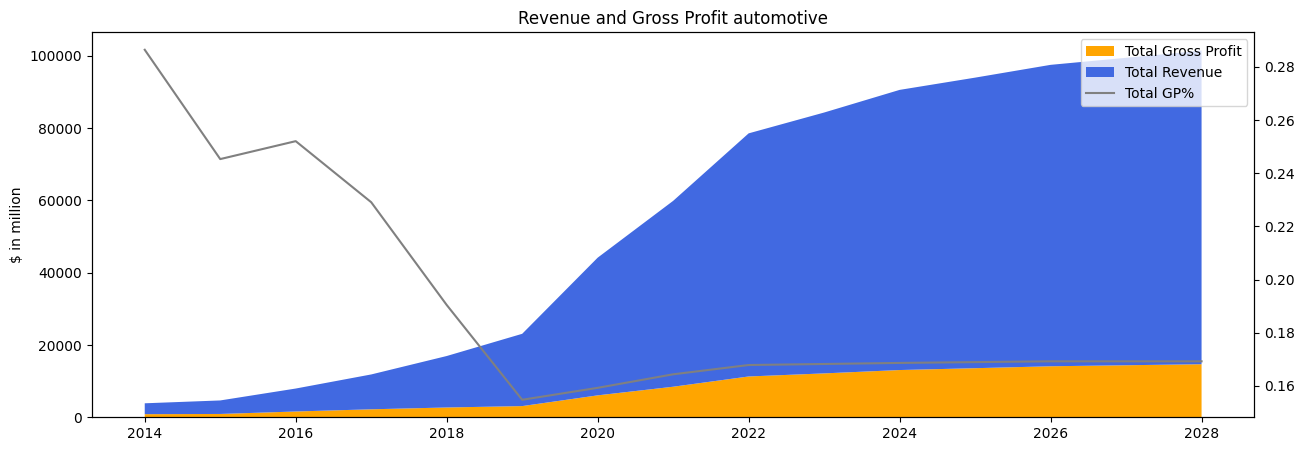

In [25]:
import matplotlib.pyplot as plt

year = [2014 + period for period in range(0, 15)]
fig, ax1 = plt.subplots(figsize=(15, 5))

ax1.stackplot(year, [dict_gross_profit_automotive["Total Gross Profit"], dict_revenue_automotive["Total Revenue"]], \
                labels=["Total Gross Profit", "Total Revenue"], \
                colors=["orange", "royalblue"])
ax1.set_ylabel('$ in million')

ax2 = ax1.twinx()
ax2.plot(df_total_gp_percent_automotive.T, color="gray", label="Total GP%")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title("Revenue and Gross Profit automotive")

### **2) Energy & Other**

**📑 [Excel sheet: Revenue Energy & Other]**

**(9) [Forecast] Forecasting 'energy' and 'services' revenue**

- 💭 **Revenue of H2 2018**

$$ Revenue \; H1 \; (first \; half \; of \; the \; year) = Revenue \; H2 \; (second \; half \; of \; the \; year) $$

- ✏️ **Revenue (2)**
$$ Revenue = Privious \; period \; revenue * (1+Growth \; rate) $$ 

In [26]:
# Initialize growth rate 
base_growth_rate = [0, 0, 0, 0, 0, 0.16, 0.12, 0.08, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06] # 2019 ~ 2028
best_growth_rate = [(growth_rate + 0.02) for growth_rate in base_growth_rate]
worst_growth_rate = [(growth_rate - 0.02) for growth_rate in base_growth_rate]

In [27]:
# Initialize revenue energy and other 
list_revenue_energy_and_other = [\
    (PnL_source["Energy generation and storage"][i] + PnL_source["Services and other"][i]) / 1000 \
    for i in range(0, 3+1)]

# 2018 : from excel file
list_revenue_energy_and_other.append(2636)

In [28]:
# index_number # 1: Best / 2: Base / 3: Worst 
def calculate_revenue_energy(index_number):
    list_revenue = [list_revenue_energy_and_other[-1]]
  
    if index_number == 1:
        growth_rate = best_growth_rate
    elif index_number == 2:
        growth_rate = base_growth_rate
    else: # index_number == 3
        growth_rate = worst_growth_rate
        
    for i in range(len(list_revenue_energy_and_other), 15):
        previous_revenue = list_revenue[-1]
        revenue = previous_revenue * (1 + growth_rate[i])
        list_revenue.append(revenue)
    return list_revenue[1:]

list_revenue_energy_and_other += calculate_revenue_energy(2) # base scenario

# Add solar city revenue
list_total_revenue_energy_and_other = list_revenue_energy_and_other.copy()
list_total_revenue_energy_and_other[0] += 255
list_total_revenue_energy_and_other[1] += 400
list_total_revenue_energy_and_other[2] += 730

In [29]:
import pandas as pd 

df_total_revenue_energy_and_other = pd.DataFrame(list_total_revenue_energy_and_other)
df_total_revenue_energy_and_other.index = year
df_total_revenue_energy_and_other = df_total_revenue_energy_and_other.T
df_total_revenue_energy_and_other.index = ["Total Revenue"]
df_total_revenue_energy_and_other

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Total Revenue,446.344,705.052,1379.366,2117.451,2636.0,3057.76,3424.6912,3698.666496,3920.586486,4155.821675,4405.170975,4669.481234,4949.650108,5246.629114,5561.426861


**📑 [Excel sheet: GP Energy & Other]**

**📑 [Excel sheet: Cost of sales Energy & Other]**

**(10) [Calculate] Calculating 'energy' and 'services' gross profit and cost of sales**

- 💭 **Gross profit**
    - (Purpose) Estimate a reasonable gross profit margin
    - (Method) Previous period gross profit margin ratio (%) is used              
        ex. 2018 gross profit margin ratio = Avg(2014~2017 gross profit margin ratio)

In [30]:
# Initialize gross profit energy & other
list_gross_profit_energy_and_other = [(PnL_source["Energy generation and storage"][i] \
                                    + PnL_source["Services and other"][i] \
                                    + PnL_source["Energy generation and storage cost of revenues"][i] \
                                    + PnL_source["Services and other cost of revenues"][i]) \
                                    / 1000 \
                                    for i in range(0, 4)
]

# Add solar city revenue
list_gross_profit_energy_and_other[0] += (255031-176432)/1000
list_gross_profit_energy_and_other[1] += (399619-280791)/1000
list_gross_profit_energy_and_other[2] += (730342-478922)/1000

In [31]:
list_gp_percent = [list_gross_profit_energy_and_other[i] \
                    / list_total_revenue_energy_and_other[i] \
                    for i in range(0, 4)
]

# Initialize GP%
base_gp_percent = sum(list_gp_percent) / len(list_gp_percent) # 15%
best_gp_percent = base_gp_percent + 0.02
worst_gp_percent = base_gp_percent - 0.02

In [32]:
# index_number # 1: Best / 2: Base / 3: Worst 
def calculate_gross_profit_energy_and_other(index_number):
    list_gross_profit = list()
  
    if index_number == 1:
        gp_percent = best_gp_percent
    elif index_number == 2:
        gp_percent = base_gp_percent
    else: # index_number == 3
        gp_percent = worst_gp_percent
        
    for i in range(4, 15): # index 4 : 2018
        revenue = list_total_revenue_energy_and_other[i]
        gross_profit = revenue * gp_percent
        list_gross_profit.append(gross_profit)
    return list_gross_profit

list_gross_profit_energy_and_other += calculate_gross_profit_energy_and_other(2) # base scenario
list_total_gross_profit_energy_and_other = list_gross_profit_energy_and_other.copy()

In [33]:
import pandas as pd 

df_total_gross_profit_energy_and_other = pd.DataFrame(list_gross_profit_energy_and_other)
df_total_gross_profit_energy_and_other.index = year
df_total_gross_profit_energy_and_other = df_total_gross_profit_energy_and_other.T
df_total_gross_profit_energy_and_other.index = ["Total Gross Profit"]
df_total_gross_profit_energy_and_other

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Total Gross Profit,99.007,124.66,249.992,13.891,386.453738,448.286336,502.080696,542.247152,574.781981,609.2689,645.825034,684.574536,725.649008,769.187948,815.339225


In [34]:
# Calculate cost of sales 
def calculate_cost_of_sales_energy_and_other():
    list_cost_of_sales = list()
    for i in range(0, len(list_total_revenue_energy_and_other)):
        revenue = list_total_revenue_energy_and_other[i]
        gross_profit = list_total_gross_profit_energy_and_other[i]
        cost_of_sales = gross_profit - revenue
        list_cost_of_sales.append(cost_of_sales)
    return list_cost_of_sales

list_total_cost_of_sales_energy_and_other = calculate_cost_of_sales_energy_and_other() 


In [35]:
import pandas as pd 

df_total_cost_of_sales_energy_and_other = pd.DataFrame(list_total_cost_of_sales_energy_and_other)
df_total_cost_of_sales_energy_and_other.index = year
df_total_cost_of_sales_energy_and_other = df_total_cost_of_sales_energy_and_other.T
df_total_cost_of_sales_energy_and_other.index = ["Total Cost of Sales"]
df_total_cost_of_sales_energy_and_other

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Total Cost of Sales,-347.337,-580.392,-1129.374,-2103.56,-2249.546262,-2609.473664,-2922.610504,-3156.419344,-3345.804505,-3546.552775,-3759.345942,-3984.906698,-4224.0011,-4477.441166,-4746.087636


### **3) Operating Expenses**

**📑 [Excel sheet: Opex Comparables]**

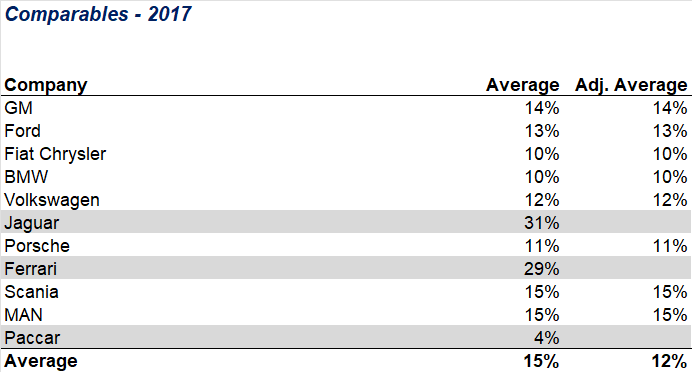

In [36]:
dict_competitive_company_op_percent = {
    "GM" : (9575+11128)/145588,
    "Ford" : (11842+6878)/144077,
    "Fiat Chrysler" : (3230+7385)/110934,
    "BMW" : (9560+1214-720)/98678,
    "Volkswagen" : (12259+8254+22710-14500)/230682,
    "Porsche" : (917-1366+1041+1883)/23491,
    "Scania" : (6587+9934+1794)/119713,
    "MAN" : (364+770+1626-655)/14342
}

In [37]:
base_op_percent = 0

for company_name in dict_competitive_company_op_percent:
    base_op_percent += dict_competitive_company_op_percent[company_name]
base_op_percent = - (base_op_percent / len(dict_competitive_company_op_percent.keys()))
best_op_percent = base_op_percent + 0.02
worst_op_percent = base_op_percent - 0.02

**📑 [Excel sheet: Opex]**

**(11) [Forecast] Forecasting operating expenses**

Operating expenses (OpEx) are the costs that a business incurs during the process of performing normal business operations (≠ cost of sales)

- 🔍 **OpEx as % of revenues** 
    - (Purpose) Estimate "OpEx as % of revenues" based on the value of similar vehicles sold on the market
    - (Information) More than three competitive companies (ex. GM, BMW, Jaguar) 's information is used
    - (Method) 
        - (1) Estimated OpEx as % = Avg(Competitive company's OpEx as %)
        - (2) Adjusted OpEx as % of revenues : remove outlier items (the highest, the lowest)
    - (Site) Each company's "OpEx as % of revenues" are reported in its balance sheet                  
    
- ✏️ **Operating Expenses**
$$ Operating \; Expenses = (OpEx \; as \; \% \; of \; revenues) * Revenues $$
- cf. (Total) Revenues = Automotive revenue + Energy & Other revevnue

In [38]:
list_total_revenue = [dict_revenue_automotive["Total Revenue"][i] \
                        + list_total_revenue_energy_and_other[i] \
                        for i in range(0, len(list_total_revenue_energy_and_other))
]

In [39]:
list_opex = [(PnL_source["Research and development"][i] \
            + PnL_source["Selling, general and administrative"][i] \
            + PnL_source["Restructuring and other"][i]) \
            / 1000 \
            for i in range(0, 4)
]

# 2018 : from excel
list_opex.append(-5095)

In [40]:
# index_number # 1: Best / 2: Base / 3: Worst 
def calculate_operating_expenses(index_number):
    list_operating_expenses = list()
  
    if index_number == 1:
        op_percent = best_op_percent
    elif index_number == 2:
        op_percent = base_op_percent
    else: # index_number == 3
        op_percent = worst_op_percent
        
    for i in range(5, len(list_total_revenue)):
        revenue = list_total_revenue[i]
        operating_expenses = revenue * op_percent
        list_operating_expenses.append(operating_expenses)
    return list_operating_expenses

list_opex += calculate_operating_expenses(2)

In [41]:
import pandas as pd 

df_opex = pd.DataFrame(list_opex)
df_opex.index = year
df_opex = df_opex.T
df_opex.index = ["Operating Expenses"]
df_opex

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Operating Expenses,-1068.36,-1640.132,-2266.597,-3854.573,-5095.0,-2880.195708,-5185.944247,-6886.034022,-8892.112658,-9535.038052,-10232.585309,-10625.441581,-11035.78532,-11281.233021,-11533.073597


## **2. Balance Sheet**

### **1) PP&E**

**📑 [Excel sheet: PP&E]**

**(12) Building a fixed asset roll forward: estimating Capex**

- ✏️ **PP&E**

$$ Ending \; PP\&E = Begining \; PP\&E + CapEx - D\&A $$

- cf. CapEx ↑ D&A ↓ → Ending PP&E ↑

- 💭 **CapEx**        
    - **(1) Model as a % of Beginning PP&E**           
        - represents the ratio at which a company intends to maintain, replace, or expand its assets concerning the previous ones       
        ex. (estimated) 2018 H2 Capex as a % of PP&E = Avg(2014~2018 H1 Capex as a % of PP&E) 
    - **(2) Model as a % of Revenues**              
        - analyzes the relationship between a company's revenue and Capital Expenditures (how Capital Expenditures may change as revenue increases)
        ex. (estimated) 2018 H2 Capex as a % of revenues = Avg(2014~2018 H1 Capex as a % of revenues)
           

- ✏️ **CapEx (Capital Expenditure)**
$$ (1) \; CapEx = Previous \; year \; ending \; PP\&E * (as \; a \; \% \; PP\&E) 
\\ = Beginning \; PP\&E * (as \; a \; \% \; PP\&E) $$  
$$ (2) \; CapEx = Revenue * (as \; a \; \% \; Revenues) $$  

In [42]:
pp_e_percent = [0.60, 0.40, 0.30, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20]
revenue_percent = [0.421, 0.421, 0.20, 0.15, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]

In [43]:
# Initialize
list_D_A = [-231931/1000, -422590/1000, -947099/1000, -1166397/1000, -1406] 
list_ending_PP_E  = [BS_source["Property, plant and equipment, net"][i]/1000 for i in range(0, 4)]
list_beginning_PP_E = [738494/1000] + list_ending_PP_E # 2014 begining PP&E : 738494/1000
list_capital_expenses = [list_ending_PP_E[i] - list_D_A[i] - list_beginning_PP_E[i] \
                        for i in range(0, min(len(list_ending_PP_E), len(list_D_A)))]

In [44]:
list_total_revenue = [dict_revenue_automotive["Total Revenue"][i] \
                        + list_revenue_energy_and_other[i] \
                        for i in range(0, len(list_revenue_energy_and_other))
]

# 2018 : from excel file
list_total_revenue[4] = 17988

In [45]:
# index_number # 1: Model as a % of Beginning PP&E / 2: Model as a % of Revenues
def calculate_capital_expenses(selected_year, index_number):
    if index_number == 1: # 1: Model as a % of Beginning PP&E
        beginning_PP_E = list_beginning_PP_E[selected_year-2014]
        capital_expenses = pp_e_percent[selected_year-2014-4] * beginning_PP_E
    else: # index_number == 2 # 2: Model as a % of Revenues
        total_revenue = list_total_revenue[selected_year-2014]
        capital_expenses = revenue_percent[selected_year-2014-4] * total_revenue
    return capital_expenses

**(13) Building a fixed asset roll forward: D&A schedule**

- ✏️ **D&A**
$$ D\&A = \frac{Previous \; year \; ending \; PP\&E}{Useful \; life \; historical \; assets} + \sum{\frac{CapEx}{Useful \; life \; CapEx}} $$
$$ = \frac{Beginning \; PP\&E}{Useful \; life \; historical \; assets} + \sum{\frac{CapEx}{Useful \; life \; CapEx}} $$ 

- 💭 **Useful life** 
    - Useful life = 15 years 

In [46]:
def calculate_D_A(selected_year):
    useful_life_capex = 15
    capital_expenses = list_capital_expenses[selected_year-2014]
    d_a = list_D_A[selected_year-2014-1] - (capital_expenses/useful_life_capex)
    return d_a

In [47]:
# Initialize 2018 
list_capital_expenses.append(calculate_capital_expenses(2018, 1))
list_ending_PP_E.append(list_beginning_PP_E[-1] + list_capital_expenses[-1] + list_D_A[-1])
list_beginning_PP_E.append(list_beginning_PP_E[-1] + list_capital_expenses[-1] + list_D_A[-1])

In [48]:
# Initialize 2019
list_capital_expenses.append(calculate_capital_expenses(2019, 1))
list_D_A.append(-(list_beginning_PP_E[-1]/15) - (list_capital_expenses[-1]/15))
list_ending_PP_E.append(list_beginning_PP_E[-1] + list_capital_expenses[-1] + list_D_A[-1])
list_beginning_PP_E.append(list_beginning_PP_E[-1] + list_capital_expenses[-1] + list_D_A[-1])

In [49]:
def fill_balance_sheet():
    for selected_year in range(2020, 2028+1):
        beginning_PP_E = list_beginning_PP_E[selected_year - 2014]
        capital_expenses = calculate_capital_expenses(selected_year, 1)
        list_capital_expenses.append(capital_expenses)
        d_a = calculate_D_A(selected_year)
        list_D_A.append(d_a)
        ending_PP_E = beginning_PP_E + capital_expenses + d_a
        list_ending_PP_E.append(ending_PP_E)
        list_beginning_PP_E.append(ending_PP_E)

fill_balance_sheet()

In [50]:
dict_PP_E = {
    "Beginning PP&E" : list_beginning_PP_E[:-1], # remove last ending PP&E 
    "CapEx" : list_capital_expenses,
    "D&A" : list_D_A,
    "Ending PP&E" : list_ending_PP_E
}

In [51]:
import pandas as pd

df_PP_E = pd.DataFrame(dict_PP_E)
year = [2014 + period for period in range(0, 15)]
df_PP_E.index = year

print("PP&E: ")
df_PP_E.T

PP&E: 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Beginning PP&E,738.494,1829.267,3403.334,5982.957,10027.5220,14638.035200,19127.032661,23116.385188,25682.686484,28419.812220,31325.432274,34394.503908,37618.796483,40986.363621,44480.959337
CapEx,1322.704,1996.657,3526.722,5210.962,6016.5132,5855.214080,5738.109798,4623.277038,5136.537297,5683.962444,6265.086455,6878.900782,7523.759297,8197.272724,8896.191867
D&A,-231.931,-422.590,-947.099,-1166.397,-1406.0000,-1366.216619,-1748.757272,-2056.975741,-2399.411561,-2778.342390,-3196.014821,-3654.608206,-4156.192159,-4702.677008,-5295.756465
Ending PP&E,1829.267,3403.334,5982.957,10027.522,14638.0352,19127.032661,23116.385188,25682.686484,28419.812220,31325.432274,34394.503908,37618.796483,40986.363621,44480.959337,48081.394739


**📑 [Excel sheet: PP&E Comparables]**

**(14) [Compare] Peer comparison: D&A as a percentage of revenues**

- 🔍 **D&A as % of revenues** 
    - (Purpose) need to check whether CapEx value is correct         
    - (Difficulty) but, difficult to find competitive companies' CapEx in their balance sheet            
    - (Alternatives) easy to find competitive companies' D&A in their balance sheet          
    (∵ When we know D&A value, CapEx can be calculated by "$ Ending \; PP\&E = Begining \; PP\&E + CapEx - D\&A $")  
    - (Information) More than three competitive companies (ex. GM, BMW, Jaguar) 's information is used
    - (Method)
        - (1) Estimated D&A as % = Avg(Competitive company's D&A as %)
        - (2) Adjusted D&A as % of revenues (or PP&E) : remove outlier items (the highest, the lowest)
    - (Site) Each company's "D&A as % of revenues (or PP&E)" are reported in its balance sheet
    

### **2) Working Capital**

**📑 [Excel sheet: Working Capital]**

**(15) [Calculate] Calculating DSO, DIO, DPO**

- ✏️ **Days Sales Outstanding (DSO)**        
How many days does it take for Tesla to collect trade receivables?   
$$ DSO = \frac{Trade \; receivable}{Revenues} * 360 \; (1 \; year ≒ 360 \; days) $$ 

- ✏️ **Days Inventory Outstanding (DIO)**        
How many days does Tesla keep inventory in its warehouse for?         
$$ DIO = -\frac{Inventory}{Cost \; of \; revenues} * 360$$

- ✏️ **Days Payable Outstanding (DPO)**           
How many days does it take for Tesla to pay trade payables?          
$$ DPO = -\frac{Accounts \; payable}{Cost \; of \; revenues} * 360$$

- 💭 **DSO, DIO, DPO** 
    - (Method) Estimated DSO, DIO, DPO = Avg(Previous period DSO, DIO, DPO)

**(17) [Calculate] Calculating investments in working capital**

- ✏️ **Trade receivables**
$$ Trade \; receivables = \frac{DSO * Revenues}{360} $$
- ✏️ **Inventory**
$$ Inventory = -\frac{DIO * COGS}{360} $$
- ✏️ **Accounts payable**
$$ Accounts \; payable = -\frac{DPO * COGS}{360} $$
- ✏️ **Net trade cycle**
$$ Net \; trade \; cycle = DSO + DIO - DPO $$ 


In [52]:
dso = sum(BS_source["DSO"]) / len(BS_source["DSO"])
dio = sum(BS_source["DIO"]) / len(BS_source["DIO"])
dpo = sum(BS_source["DPO"]) / len(BS_source["DPO"])

In [53]:
list_trade_receivables = [BS_source["Accounts receivable, net"][i] / 1000 for i in range(0, 4)]
list_inventory = [BS_source["Inventory"][i] / 1000 for i in range(0, 4)]
list_trade_payables = [BS_source["Accounts payable"][i] / 1000 for i in range(0, 4)]

In [54]:
# Total cost of sales 
# [Automotive] Total cost of sales
list_total_cost_of_sales_automotive = list()
for selected_year in year:
    df_transposed_cost_of_sales_automotive = df_cost_of_sales_automotive.T
    total_cost_of_sales = sum(df_transposed_cost_of_sales_automotive[selected_year])
    list_total_cost_of_sales_automotive.append(total_cost_of_sales)
    
# 2014 ~ 2018 : from excel file
for i in range(0, 4):
    list_total_cost_of_sales_automotive[i] = PnL_source["Automotive cost of revenues"][i] / 1000
list_total_cost_of_sales_automotive[4] = -11525

# [Energy and other] Total cost of sales
list_total_cost_of_sales = [list_total_cost_of_sales_automotive[i] \
                            + list_total_cost_of_sales_energy_and_other[i] \
                            for i in range(0, len(list_total_cost_of_sales_automotive))]

# Remove solar city revenue, gross profit
list_total_cost_of_sales[0] += - (255031-176432)/1000 + 255
list_total_cost_of_sales[1] += - (399619-280791)/1000 + 400
list_total_cost_of_sales[2] += - (730342-478922)/1000 + 730

# 2018 : from excel file
list_total_cost_of_sales[4] = -14891

In [55]:
def calculate_trade_receivables():
    list_tr = list()
    for i in range(4, 15): # index 4 : 2018 # index 14: 2028
        revenues = list_total_revenue[i]
        trade_receivables = dso * revenues / 360 
        list_tr.append(trade_receivables)
    return list_tr

list_trade_receivables += calculate_trade_receivables()

In [56]:
def calculate_inventory():
    list_inv = list()
    for i in range(4, 15): # index 4 : 2018 # index 14: 2028
        cost_of_sales = list_total_cost_of_sales[i]
        inventory = - dio * cost_of_sales / 360 
        list_inv.append(inventory)
    return list_inv

list_inventory += calculate_inventory()

In [57]:
def calculate_trade_payables():
    list_tp = list()
    for i in range(4, 15): # index 4 : 2018 # index 14: 2028
        cost_of_sales = list_total_cost_of_sales[i]
        trade_payables = - dpo * cost_of_sales / 360 
        list_tp.append(trade_payables)
    return list_tp

list_trade_payables += calculate_trade_payables()

In [58]:
def calculate_net_trade_cycle():
    list_nc = list()
    for i in range(0, len(list_trade_receivables)):
        trade_receivables = list_trade_receivables[i]
        inventory = list_inventory[i]
        trade_payables = list_trade_payables[i]
        list_nc.append(trade_receivables+inventory-trade_payables)
    return list_nc
    
list_net_trade_cycle = calculate_net_trade_cycle()

In [59]:
dict_working_capital = {
    "Trade Receivables" : list_trade_receivables,
    "Inventory" : list_inventory,
    "Trade Payables" : list_trade_payables,
    "Net Trade Cycle" : list_net_trade_cycle
}

In [60]:
import pandas as pd

df_working_capital= pd.DataFrame(dict_working_capital)
year = [2014 + period for period in range(0, 15)]
df_working_capital.index = year

print("Working Capital: ")
df_working_capital.T

Working Capital: 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Trade Receivables,226.604,168.965,499.142,515.381,957.661133,1227.513622,2210.203004,2934.766043,3789.738796,4063.747842,4361.036237,4528.468063,4703.352890,4807.960503,4915.292701
Inventory,953.675,1277.838,2067.454,2263.537,5073.198244,6647.949744,11905.882599,15716.140743,20209.480883,21660.745848,23234.453273,24118.885564,25042.505969,25600.918898,26173.953854
Trade Payables,777.946,916.148,1860.341,2390.250,4358.430244,5711.313422,10228.450832,13501.877877,17362.146808,18608.941593,19960.927797,20720.751533,21514.242131,21993.979701,22486.279187
Net Trade Cycle,402.333,530.655,706.255,388.668,1672.429133,2164.149943,3887.634770,5149.028910,6637.072871,7115.552097,7634.561713,7926.602093,8231.616728,8414.899699,8602.967369


### **3) Financing**

**📑 [Excel sheet: Financing]**

**(22) [Modeling] Modeling Tesla's financing needs in the forecast period**

- 💭 **Financing** 
    - (1) **Assumption 1**     
        When UFCF (Unlevered Free Cash Flow) < 0, Tesla raises financing on the first day of the following year.   
    - (2) **Assumption 2**               
        Tesla will use 50% debt and 50% equity financing to cover negative cash flows.                
        - Debt = max(-Unlevered free cash flow * Debt ratio (ex. 0.50), 0)  
        - Equity = max(-Unlevered free cash flow * Equity ratio (ex. 0.50), 0)          
    - (3) **Assumption 3**               
        The company's cost of debt remains flat throughout the entire forecast period. 

- ✏️ **Debt**
$$ Outstanding \; debt \; (end \; of \; 2018) = Outstanding \; debt \; (end \; of \; 2017) 
\\ + Newly \; raised \; debt \; (2018) $$ 

- ✏️ **Interest expense**
$$ Interest \; expense = Outstanding \; debt * Interest \; rate $$ 

In [61]:
debt_ratio = 0.50 # 50%
equity_ratio = 0.50 # 50%

### ⚠️ "NameError: name 'list_unlevered_free_cash_flow' is not defined"
Please execute **(16) Fill in the P&L output sheet** first.   
→ **(17)**           
→ **(18)**        
→ **(19)**         
→ **(20)**        
→ **(21)**    
→ **(22)**    
→ **(20)**   

In [98]:
# Debt 
list_debt = [- min(list_unlevered_free_cash_flow[i] * debt_ratio, 0) \
            for i in range(5, len(list_unlevered_free_cash_flow))]
list_debt = [0] * (15-len(list_debt)) + list_debt

In [99]:
# Equity
list_equity = [- min(list_unlevered_free_cash_flow[i] * equity_ratio, 0) \
            for i in range(5, len(list_unlevered_free_cash_flow))]
list_equity = [0] * (15-len(list_equity)) + list_equity

In [100]:
# Long-term debt and capital leases, net of current
list_long_term_debt_and_others = [BS_source["Long-term debt and capital leases, net of current portion"][i] \
                        / 1000 \
                        for i in range(0, 4)]

# 2018 : from excel file 
list_long_term_debt_and_others.append((BS_source["Long-term debt and capital leases, net of current portion"][4] \
                            + list_debt[4]) / 1000)

In [101]:
def calculate_long_term_debt_and_others():
    list_ltd = [list_long_term_debt_and_others[-1]]
    for i in range(5, 15):
        current_debt = list_debt[i-1]
        previous_long_term = list_ltd[-1]
        long_term_debt = previous_long_term + current_debt 
        list_ltd.append(long_term_debt)
    return list_ltd

list_long_term_debt_and_others += calculate_long_term_debt_and_others()[1:]

In [102]:
# Interest expense
list_interest_expenses = [PnL_source["Interest expense"][i] / 1000 for i in range(0, 4)]

# Interest rate 
list_interest_rate = [list_interest_expenses[i] / list_long_term_debt_and_others[i] \
                        for i in range(0, len(list_interest_expenses))]
list_interest_rate += [bond_yield] * (15 - len(list_interest_rate))

# Interest expense
list_interest_expenses += [- list_long_term_debt_and_others[i] * list_interest_rate[i] for i in range(4, 15)]

In [103]:
dict_financing = {
    "Long-term debt and capital leases, net of current": list_long_term_debt_and_others,
    "Interest expense" : list_interest_expenses,
    "Interest rate" : list_interest_rate,
    "Unlevered Free Cash Flow" : [0] * 5 + list_unlevered_free_cash_flow[5:],
    "Debt" : list_debt,
    "Equity" : list_equity
}

In [104]:
import pandas as pd

df_financing = pd.DataFrame(dict_financing)
year = [2014 + period for period in range(0, 15)]
df_financing.index = year

print("Financing: ")
df_financing.T

Financing: 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
"Long-term debt and capital leases, net of current",1818.785000,2021.093000,5860.049000,9415.70000,9513.39000,9513.39000,9881.256850,9881.256850,9881.256850,9881.256850,9881.256850,9881.256850,9881.256850,9881.256850,9881.256850
Interest expense,-100.886000,-118.851000,-198.810000,-471.25900,-713.50425,-713.50425,-741.094264,-741.094264,-741.094264,-741.094264,-741.094264,-741.094264,-741.094264,-741.094264,-741.094264
Interest rate,-0.055469,-0.058805,-0.033926,-0.05005,0.07500,0.07500,0.075000,0.075000,0.075000,0.075000,0.075000,0.075000,0.075000,0.075000,0.075000
Unlevered Free Cash Flow,0.000000,0.000000,0.000000,0.00000,0.00000,-735.73370,9022.566989,7799.201521,9833.682161,2706.142459,3015.424810,1377.082066,1439.720072,506.069078,491.170329
Debt,0.000000,0.000000,0.000000,0.00000,0.00000,367.86685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Equity,0.000000,0.000000,0.000000,0.00000,0.00000,367.86685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


**📑 [Excel sheet: WACC]**

**(26) [Estimate] Estimating Weighted average cost of capital (WACC)**

- 💭 **Cost of debt** 
    - (Method) Cost of debt ≒ Bond yield as of the 19th of September 2018          

- 💭 **Risk free rate** 
    - the rate of return that an investor would expect from a financial security that contains zero default risks
    - (Method) Risk free rate ≒ 10 year government bond       

- 🔍 **Beta** 
    - how a financial security behaves with respect to the rest of the market  

- 🔍 **Market risk premium**            
    - the extra returns investors in a maket require in order to invest in equity and bear additional risk            
    - It has been proven empirically that the average market risk premium investors require varies between 4.5% and 5.5% in different economies, for the U.S. will use a market risk premium of ***5%***

- 💭 **Cost of equity** 
    - (Method) The capital asset pricing model (CAPM) suggests that a company's cost of equity is equal to $ Cost \; of \; equity = Risk \; free \; rate + Beta * Market \; risk \; premium $

- ✏️ **WACC**
$$ WACC = \frac{Debt}{Debt+Equity}*k_d*(1-t) + \frac{Equity}{Debt+Equity}*k_e $$    
- Debt : Long-term debt (in balance sheet)
- Equity : Equity (in balance sheet)        
- $k_d$ : Cost of debt       
- $k_e$ : Cost of equity         
- t : tax rate      


In [133]:
# Debt / (Debt + Equity)
list_debt_ratio = [list_long_term_debt[i] / (list_long_term_debt[i] + list_total_equity[i])
                   for i in range(0, 15)]

# Equity / (Debt + Equity)
list_equity_ratio = [list_total_equity[i] / (list_long_term_debt[i] + list_total_equity[i])
                   for i in range(0, 15)]

In [134]:
# Cost of equity # Cost of debt
risk_free_rate = ten_year_treasury_yield        # from drivers
market_risk_premium = market_risk_premium_US    # from drivers
beta = company_beta                             # from drivers

cost_of_equity = risk_free_rate + beta * market_risk_premium
cost_of_debt = bond_yield

In [135]:
tax_rate = corporate_tax_rate                   # from drivers

list_WACC = [
    list_debt_ratio[i] * cost_of_debt * (1-tax_rate)
    + list_equity_ratio[i] * cost_of_equity
    for i in range(0, 15)
]

In [136]:
dict_WACC = {
    "Debt" : list_long_term_debt,
    "Equity" : list_total_equity,
    "Debt / (Debt + Equity)" : list_debt_ratio,
    "Equity / (Debt + Equity)" : list_equity_ratio,
    "WACC" : list_WACC
}

In [137]:
import pandas as pd

df_WACC = pd.DataFrame(dict_WACC)
year = [2014 + period for period in range(0, 15)]
df_WACC.index = year

print("WACC: ")
df_WACC.T

WACC: 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Debt,2429.884000,2649.020000,6844.260000,10212.249000,11617.000000,11984.866850,11984.866850,11984.866850,11984.866850,11984.866850,11984.866850,11984.866850,11984.866850,11984.866850,11984.866850
Equity,911.710000,1083.704000,5538.086000,5234.588000,4088.113000,4405.733192,4854.635145,5811.447582,7373.140580,9105.677613,11025.329171,13054.214348,15197.567829,17397.169476,19654.324597
Debt / (Debt + Equity),0.727163,0.709675,0.552743,0.661122,0.739695,0.731204,0.711711,0.673447,0.619117,0.568258,0.520850,0.478646,0.440905,0.407898,0.378798
Equity / (Debt + Equity),0.272837,0.290325,0.447257,0.338878,0.260305,0.268796,0.288289,0.326553,0.380883,0.431742,0.479150,0.521354,0.559095,0.592102,0.621202
WACC,0.057193,0.057494,0.060193,0.058329,0.056977,0.057123,0.057459,0.058117,0.059051,0.059926,0.060741,0.061467,0.062116,0.062684,0.063185


## **3. Output**

### **1) P&L**

**📑 [Excel sheet: P&L]**

**(16) Fill in the P&L output sheet**

- ✏️ **EBIT**
$$ EBIT = Gross \; profit + Operating \; expenses  $$

In [64]:
# Total Gross profit 
list_total_gross_profit = [list_total_revenue[i] + list_total_cost_of_sales[i] \
                            for i in range(0, len(list_total_revenue))]

# EBIT
list_EBIT = [list_total_gross_profit[i] + list_opex[i] \
            for i in range(0, len(list_opex))]

**(23) [Calculate] Calculating net income**

- ✏️ **Taxes**
    - If EBT is positive, and pay taxes only when it is. And, $Taxes = EBT * Tax rate $     
$$ Taxes = max(EBT * Tax \; rate, \; 0) $$      

- ✏️ **Net income**
$$ Net \; income = EBT + Taxes + Minority \; interest  $$  

- 💭 **Minority interests**     
    - Minority interests will be equal to zero in the forecast period.      

In [107]:
# Interest expenses/income 
list_interest_expenses_income = [list_interest_expenses[i] \
                                + (PnL_source["Interest income"][i] \
                                + PnL_source["Other income (expense), net"][i]) \
                                / 1000 \
                                for i in range(0, 4)]

list_interest_expenses_income += list_interest_expenses[4:]

In [109]:
# EBT
list_EBT = [list_EBIT[i] + list_interest_expenses_income[i] \
            for i in range(0, 15)]

In [110]:
# Taxes 
list_taxes = [PnL_source["Provision for income taxes"][i] / 1000 for i in range(0, 4)]
list_taxes += [0] * 2

def calculate_taxes():
    list_t = list()
    for i in range(6, 15):
        EBT = list_EBT[i]
        taxes = - max(EBT * corporate_tax_rate, 0)
        list_t.append(taxes)
    return list_t

list_taxes += calculate_taxes()

In [111]:
# Minority interest
list_minority_interest = [PnL_source["Minority interests"][i] / 1000 \
                            for i in range(0, 4)]
list_minority_interest += [0] * (15-4)

In [112]:
# Net income
list_net_income = [list_EBT[i] + list_taxes[i] + list_minority_interest[i] \
                    for i in range(0, 15)]

In [113]:
dict_PnL = {
    "Revenues" : list_total_revenue,
    "Cost of Sales" : list_total_cost_of_sales,
    "Gross Profit" : list_total_gross_profit,
    "Operating Expenses" : list_opex,
    "EBIT" : list_EBIT,
    "Interest expenses/income" : list_interest_expenses_income,
    "EBT" : list_EBT,
    "Taxes" : list_taxes,
    "Minority interest" : list_minority_interest,
    "Net Income" : list_net_income,
}

In [114]:
import pandas as pd

df_PnL = pd.DataFrame(dict_PnL)
year = [2014 + period for period in range(0, 15)]
df_PnL.index = year

print("P&L: ")
df_PnL.T

P&L: 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Revenues,3198.356,4046.025,7000.132,11758.751,17988.00000,23056.710000,41514.822152,55124.479580,71183.656820,76330.440531,81914.486354,85059.402203,88344.309743,90309.181942,92325.230745
Cost of Sales,-2316.685,-3122.522,-5400.875,-9536.264,-14891.00000,-19513.256701,-34946.495137,-46130.476384,-59319.459901,-63579.255311,-68198.447412,-70794.458963,-73505.496614,-75144.566590,-76826.555569
Gross Profit,881.671,923.503,1599.257,2222.487,3097.00000,3543.453299,6568.327015,8994.003196,11864.196919,12751.185220,13716.038942,14264.943239,14838.813129,15164.615352,15498.675177
Operating Expenses,-1068.360,-1640.132,-2266.597,-3854.573,-5095.00000,-2880.195708,-5185.944247,-6886.034022,-8892.112658,-9535.038052,-10232.585309,-10625.441581,-11035.785320,-11281.233021,-11533.073597
EBIT,-186.689,-716.629,-667.340,-1632.086,-1998.00000,663.257591,1382.382768,2107.969174,2972.084261,3216.147168,3483.453633,3639.501659,3803.027809,3883.382330,3965.601580
Interest expenses/income,-97.947,-158.995,-79.008,-576.946,-713.50425,-713.504250,-741.094264,-741.094264,-741.094264,-741.094264,-741.094264,-741.094264,-741.094264,-741.094264,-741.094264
EBT,-284.636,-875.624,-746.348,-2209.032,-2711.50425,-50.246659,641.288504,1366.874911,2230.989997,2475.052904,2742.359369,2898.407395,3061.933545,3142.288066,3224.507316
Taxes,-9.404,-13.039,-26.698,-31.546,0.00000,0.000000,-192.386551,-410.062473,-669.296999,-742.515871,-822.707811,-869.522218,-918.580063,-942.686420,-967.352195
Minority interest,0.000,0.000,98.132,279.178,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Net Income,-294.040,-888.663,-674.914,-1961.400,-2711.50425,-50.246659,448.901953,956.812437,1561.692998,1732.537033,1919.651559,2028.885176,2143.353481,2199.601646,2257.155121


### **2) Balance Sheet**

**📑 [Excel sheet: Balance Sheet]**

**(19) [Forecast] Forecasting other assets**

- 💭 **Other assets**          
    - (1) **Restricted cash and securities**'s growth rate is flat  
        - ex. (H2 2018 ~) Restricted cash and securities = (H1 2018) Restricted cash and securities                  
    - (2) **Prepaid expenses**'s grows with the same pace as revenues
        - (Method) Prepaid expenses = (Prepaid expenses as a % of revenues) * Revenues 
        - ex. (H2 2018 ~) prepaid expenses as a % of revenues = Avg(2016 ~ H1 2018 prepaid expenses as a % of revenues)     
    - (3) **Cash** can not be filled before calculate Tesla's actual net cash flow           
    - (4) **Operating lease vehicles**'s growth rate is flat 
        - (Reason) leases services are not part of the company's core business        
        - ex. (H2 2018 ~) Operating lease vehicles = (H1 2018) Operating lease vehicles       
    - (5) **Solar energy systems leased**'s growth rate is flat 
        - (Reason) leases services are not part of the company's core business
        - ex. (H2 2018 ~) Solar energy systems leased = (H1 2018) Solar energy systems leased 
    - (6) **Intangible assets**'s growth rate is flat 
        - (Reason) intangible assets are not directly related to the company's business growth   
        - ex. (H2 2018 ~) Intangible assets = (H1 2018) Intangible assets
    - (7) **Ohter assets**'s grows with the same pace as revenues
        - (Method) $ Other \; assets = (Other \; assets \; as \; a \; \% \; of \; revenues) * Revenues $ 
        - ex. (H2 2018 ~) Ohter assets as a % of revenues = Avg(2016 ~ H1 2018 Ohter assets as a % of revenues)   

In [73]:
# Initialize other assets
list_other_assets = [(BS_source["Other portion"][i] \
                    + BS_source["Restricted cash, net of current portion"][i] \
                    + BS_source["Other assets"][i]) \
                    / 1000 \
                    for i in range(0, 4)
]

In [74]:
list_revenue_percent = [list_other_assets[i] / list_total_revenue[i] \
                        for i in range(2, len(list_other_assets))]

# 2018 H1 : from excel file 
other_assets_in_2018_H1 = (BS_source["Other portion"][4] \
                        + BS_source["Restricted cash, net of current portion"][4] \
                        + BS_source["Other assets"][4]) \
                        / 1000
revenues_in_2018_H1 = (PnL_source["Automotive revenues"][4] \
                    + PnL_source["Energy generation and storage"][4] \
                    + PnL_source["Services and other"][4]) \
                    / 1000        
list_revenue_percent.append(other_assets_in_2018_H1/revenues_in_2018_H1)

reveneue_percent_in_other_assets = sum(list_revenue_percent) / len(list_revenue_percent) # average 

In [75]:
def calculate_other_assets():
    list_os = list()
    for i in range(4, 15):
        revenues = list_total_revenue[i]
        other_assets = revenues * reveneue_percent_in_other_assets 
        list_os.append(other_assets)
    return list_os

list_other_assets += calculate_other_assets()

In [76]:
# Restricted cash and securities
list_restricted_cash_and_securities = [BS_source["Restricted cash and marketable securities"][i] \
                                        / 1000 \
                                        for i in range(0, 5)]

# Assumption: Stays flat
list_restricted_cash_and_securities += [list_restricted_cash_and_securities[-1]] \
                                    * (15 - len(list_restricted_cash_and_securities))

In [77]:
# Prepaid expenses and other current assets
list_prepaid_expenses = [BS_source["Prepaid expenses and other current assets"][i] \
                                        / 1000 \
                                        for i in range(0, 4)]

# Grows as a % of revenues
list_revenue_percent_prepaid_expenses = [list_prepaid_expenses[i] / list_total_revenue[i] \
                                        for i in range(0, len(list_prepaid_expenses))]

# 2018 H1 : from excel file 
prepaid_expenses_in_2018_H1 = BS_source["Prepaid expenses and other current assets"][4] / 1000
revenues_in_2018_H1 = (PnL_source["Automotive revenues"][4] \
                    + PnL_source["Energy generation and storage"][4] \
                    + PnL_source["Services and other"][4]) \
                    / 1000        
list_revenue_percent_prepaid_expenses.append(prepaid_expenses_in_2018_H1/revenues_in_2018_H1)

reveneue_percent_in_prepaid_expenses = sum(list_revenue_percent_prepaid_expenses) \
                                    / len(list_revenue_percent_prepaid_expenses) # average 

In [78]:
def calculate_prepaid_expenses():
    list_pe = list()
    for i in range(4, 15):
        revenues = list_total_revenue[i]
        prepaid_expenses = revenues * reveneue_percent_in_prepaid_expenses 
        list_pe.append(prepaid_expenses)
    return list_pe

list_prepaid_expenses += calculate_prepaid_expenses()

In [79]:
# Operating lease vehicles
list_operating_lease_vehicles = [BS_source["Operating lease vehicles, net"][i] \
                                / 1000 \
                                for i in range(0, 5)]

# Assumption: Stays flat
list_operating_lease_vehicles += [list_operating_lease_vehicles[-1]] \
                                * (15 - len(list_operating_lease_vehicles))

In [80]:
# Solar energy systems leased
list_solar_energy_systems_leased = [BS_source["Solar energy systems, leased and to be leased, net"][i] \
                                / 1000 \
                                for i in range(0, 5)]

# Assumption: Stays flat
list_solar_energy_systems_leased += [list_solar_energy_systems_leased[-1]] \
                                * (15 - len(list_solar_energy_systems_leased))

In [81]:
# Intangible assets
list_intangible_assets = [BS_source["Intangible assets, net"][i] \
                                / 1000 \
                                for i in range(0, 5)]

# Assumption: Stays flat
list_intangible_assets += [list_intangible_assets[-1]] \
                                * (15 - len(list_intangible_assets))

**(20) [Forecast] Forecasting other liabilities**

- 💭 **Other liabilities**          
    - (1) **Accured liabilities**'s grows with the same pace as revenues
        - (Method) $ Accured \; liabilities = (Accured \; liabilities \; as \; a \; \% \; of \; revenues) * Revenues $
        - ex. (H2 2018 ~) Accured liabilities as a % of revenues = Avg(2014 ~ H1 2018 Accured liabilities as a % of revenues)   
     - (2) **Deferred revenue**'s grows with the same pace as revenues
        - (Method) $ Deferred \; revenue = (Deferred \; revenue \; as \; a \; \% \; of \; revenues) * Revenues $
        - ex. (H2 2018 ~) Deferred revenue as a % of revenues = Avg(2014 ~ H1 2018 Deferred revenue as a % of revenues)     
    - (3) **Resale value of guarantees**'s grows with the same pace as revenues        
        - (Method) $ Resale \; value \; of \; guarantees = (Resale \; value \; of \; guarantees \; as \; a \; \% \; of \; revenues) * Revenues $ 
        - ex. (H2 2018 ~) Resale value of guarantees as a % of revenues = Avg(2014 ~ H1 2018 Resale value of guarantees as a % of revenues)         
    - (4) **Customer deposits**'s grows with the same pace as revenues     
        - (Method) $ Customer \; deposits = (Customer \; deposits \; as \; a \; \% \; of \; revenues) * Revenues $          
        - ex. (H2 2018 ~) Customer deposits as a % of revenues = Avg(2014 ~ H1 2018 Customer deposits as a % of revenues)       
    - (5) **Long-term debt** can not be filled before calculate Tesla's unleveraged free cash flow     
    - (6) **Ohter liabilties**'s grows with the same pace as revenues
        - (Method) $ Other \; liabilties = (Other \; liabilties \; as \; a \; \% \; of \; revenues) * Revenues $ 
        - ex. (H2 2018 ~) Other liabilties as a % of revenues = Avg(2016 ~ H1 2018 Other liabilties as a % of revenues)    

In [82]:
# Accrued liabilities
list_accured_liabilities = [BS_source["Accrued liabilities"][i] \
                            / 1000 \
                            for i in range(0, 4)]

# Grows as a % of revenues
list_revenue_percent_accured_liabilities = [list_accured_liabilities[i] / list_total_revenue[i] \
                                            for i in range(0, len(list_accured_liabilities))]

# 2018 H1 : from excel file 
accured_liabilities_in_2018_H1 = BS_source["Accrued liabilities"][4] / 1000
revenues_in_2018_H1 = (PnL_source["Automotive revenues"][4] \
                    + PnL_source["Energy generation and storage"][4] \
                    + PnL_source["Services and other"][4]) \
                    / 1000        
list_revenue_percent_accured_liabilities.append(accured_liabilities_in_2018_H1/revenues_in_2018_H1)

reveneue_percent_in_accured_liabilities = sum(list_revenue_percent_accured_liabilities) \
                                    / len(list_revenue_percent_accured_liabilities) # average 

In [83]:
def calculate_accured_liabilities():
    list_al = list()
    for i in range(4, 15):
        revenues = list_total_revenue[i]
        accured_liabilities = revenues * reveneue_percent_in_accured_liabilities 
        list_al.append(accured_liabilities)
    return list_al

list_accured_liabilities += calculate_accured_liabilities()

In [84]:
# Deferred revenue
list_deferred_revenue = [BS_source["Deferred revenue"][i] \
                        / 1000 \
                        for i in range(0, 4)]

# Grows as a % of revenues
list_revenue_percent_deferred_revenue = [list_deferred_revenue[i] / list_total_revenue[i] \
                                        for i in range(0, len(list_deferred_revenue))]

# 2018 H1 : from excel file 
deferred_revenue_in_2018_H1 = BS_source["Deferred revenue"][4] / 1000
revenues_in_2018_H1 = (PnL_source["Automotive revenues"][4] \
                    + PnL_source["Energy generation and storage"][4] \
                    + PnL_source["Services and other"][4]) \
                    / 1000        
list_revenue_percent_deferred_revenue.append(deferred_revenue_in_2018_H1/revenues_in_2018_H1)

reveneue_percent_in_deferred_revenue = sum(list_revenue_percent_deferred_revenue) \
                                    / len(list_revenue_percent_deferred_revenue) # average 

In [85]:
def calculate_deferred_revenue():
    list_dr = list()
    for i in range(4, 15):
        revenues = list_total_revenue[i]
        deferred_revenue = revenues * reveneue_percent_in_deferred_revenue 
        list_dr.append(deferred_revenue)
    return list_dr

list_deferred_revenue += calculate_deferred_revenue()

In [86]:
# Resale value guarantees
list_resale_value_guarantees = [BS_source["Resale value guarantees"][i] \
                                / 1000 \
                                for i in range(0, 4)]

# Grows as a % of revenues
list_revenue_percent_resale_value_guarantees = [list_resale_value_guarantees[i] / list_total_revenue[i] \
                                        for i in range(0, len(list_resale_value_guarantees))]

# 2018 H1 : from excel file 
resale_value_guarantees_in_2018_H1 = BS_source["Resale value guarantees"][4] / 1000
revenues_in_2018_H1 = (PnL_source["Automotive revenues"][4] \
                    + PnL_source["Energy generation and storage"][4] \
                    + PnL_source["Services and other"][4]) \
                    / 1000        
list_revenue_percent_resale_value_guarantees.append(resale_value_guarantees_in_2018_H1/revenues_in_2018_H1)

reveneue_percent_in_resale_value_guarantees = sum(list_revenue_percent_resale_value_guarantees) \
                                    / len(list_revenue_percent_resale_value_guarantees) # average 

In [87]:
def calculate_resale_value_guarantees():
    list_rvg = list()
    for i in range(4, 15):
        revenues = list_total_revenue[i]
        resale_value_guarantees = revenues * reveneue_percent_in_resale_value_guarantees 
        list_rvg.append(resale_value_guarantees)
    return list_rvg

list_resale_value_guarantees += calculate_resale_value_guarantees()

In [88]:
# Customer deposits
list_customer_deposits = [BS_source["Customer deposits"][i] \
                                / 1000 \
                                for i in range(0, 4)]

# Grows as a % of revenues
list_revenue_percent_customer_deposits = [list_customer_deposits[i] / list_total_revenue[i] \
                                        for i in range(0, len(list_customer_deposits))]

# 2018 H1 : from excel file 
customer_deposits_in_2018_H1 = BS_source["Customer deposits"][4] / 1000
revenues_in_2018_H1 = (PnL_source["Automotive revenues"][4] \
                    + PnL_source["Energy generation and storage"][4] \
                    + PnL_source["Services and other"][4]) \
                    / 1000        
list_revenue_percent_customer_deposits.append(customer_deposits_in_2018_H1/revenues_in_2018_H1)

reveneue_percent_in_customer_deposits = sum(list_revenue_percent_customer_deposits) \
                                    / len(list_revenue_percent_customer_deposits) # average 

In [89]:
def calculate_customer_deposits():
    list_cd = list()
    for i in range(4, 15):
        revenues = list_total_revenue[i]
        customer_deposits = revenues * reveneue_percent_in_customer_deposits 
        list_cd.append(customer_deposits)
    return list_cd

list_customer_deposits += calculate_customer_deposits()

In [94]:
# Other liabilities
list_other_liabilities = [(BS_source["Current portion of solar bonds issued to related parties"][i] \
                            + BS_source["Other liabilities"][i]) \
                            / 1000 \
                            for i in range(0, 4)]

# Grows as a % of revenues
list_revenue_percent_other_liabilities = [list_other_liabilities[i] / list_total_revenue[i] \
                                        for i in range(0, len(list_other_liabilities))]

# 2018 H1 : from excel file 
other_liabilities_in_2018_H1 = \
        (BS_source["Current portion of solar bonds issued to related parties"][4] \
        + BS_source["Other liabilities"][4]) / 1000
revenues_in_2018_H1 = (PnL_source["Automotive revenues"][4] \
                    + PnL_source["Energy generation and storage"][4] \
                    + PnL_source["Services and other"][4]) \
                    / 1000        
list_revenue_percent_other_liabilities.append(other_liabilities_in_2018_H1/revenues_in_2018_H1)

reveneue_percent_in_other_liabilities = sum(list_revenue_percent_other_liabilities) \
                                    / len(list_revenue_percent_other_liabilities) # average 

In [95]:
def calculate_other_liabilities():
    list_ol = list()
    for i in range(4, 15):
        revenues = list_total_revenue[i]
        other_liabilities = revenues * reveneue_percent_in_other_liabilities 
        list_ol.append(other_liabilities)
    return list_ol

list_other_liabilities += calculate_other_liabilities()

### ⚠️ NameError: name 'list_debt' is not defined
Please execute **(21) Completing unlevered free cash flow** first.

In [105]:
# Long term debt 
list_long_term_debt = [(BS_source["Current portion of long-term debt and capital leases"][i] \
                        + BS_source["Long-term debt and capital leases, net of current portion"][i]) \
                        / 1000 \
                        for i in range(0, 4)]

# 2018 : from excel file
list_long_term_debt.append(11617)

def calculate_long_term_debt():
    list_ltd = [list_long_term_debt[-1]]
    for i in range(5, 15):
        previous_long_term_debt = list_ltd[-1]
        current_debt = list_debt[i]
        long_term_debt = previous_long_term_debt + current_debt
        list_ltd.append(long_term_debt)
    return list_ltd

list_long_term_debt += calculate_long_term_debt()[1:]

### ⚠️ NameError: name 'list_net_income' is not defined
Please execute **(23) [Calculate] Calculating net income** first.

In [115]:
# Equity 
list_total_equity = [(BS_source["Total stockholders' equity"][i] \
                    + BS_source["Noncontrolling interests in subsidiaries"][i]) \
                    / 1000 \
                    for i in range(0, 4)]
# 2018 : from excel file
list_total_equity.append((BS_source["Total stockholders' equity"][4] \
                        + BS_source["Noncontrolling interests in subsidiaries"][4]) \
                        / 1000 \
                        + list_equity[4] \
                        + (-1179) # net_income in H2 2018 \
)

def calcualte_total_equity():
    list_te = [list_total_equity[-1]]
    for i in range(5, 15):
        previous_equity = list_te[-1]
        net_income = list_net_income[i]
        current_equity = list_equity[i]
        equity = previous_equity + net_income + current_equity
        list_te.append(equity)
    return list_te

list_total_equity += calcualte_total_equity()[1:]

### ⚠️ NameError: name 'list_net_cash_flow' is not defined
Please execute **(24) [Output] Bridging unlevered free cash flow to net cash flow** first.

In [124]:
# Cash 
list_cash = [BS_source["Cash and cash equivalents"][i] / 1000 for i in range(0, 4)]

# 2018 : from excel
list_cash.append(3678)

def calculate_cash():
    list_c = [list_cash[-1]]
    for i in range(5, 15):
        previous_cash = list_c[-1]
        current_cash_flow = list_net_cash_flow[i]
        cash = previous_cash + current_cash_flow
        list_c.append(cash)
    return list_c

list_cash += calculate_cash()[1:]

In [125]:
# Total Assets
list_total_assets = [
    list_cash[i]
    + list_restricted_cash_and_securities[i]
    + list_trade_receivables[i]
    + list_inventory[i]
    + list_prepaid_expenses[i]
    + list_operating_lease_vehicles[i]
    + list_solar_energy_systems_leased[i]
    + list_ending_PP_E[i]
    + list_intangible_assets[i]
    + list_other_assets[i]
    for i in range(0, 15)
]

In [126]:
# Total Liabilities
list_total_liabilities = [
    list_trade_payables[i]
    + list_accured_liabilities[i]
    + list_deferred_revenue[i]
    + list_resale_value_guarantees[i]
    + list_customer_deposits[i]
    + list_long_term_debt[i]
    + list_other_liabilities[i]
    for i in range(0, 15)
]

In [127]:
# Total Liabilities & Equity
list_total_liabilities_and_equity = [
    list_total_liabilities[i]
    + list_total_equity[i]
    for i in range(0, 15)
]

In [128]:
dict_balance_sheet = {
    "Cash" : list_cash,
    "Restricted cash and securities" : list_restricted_cash_and_securities,
    "Trade receivables" : list_trade_receivables,
    "Inventory" : list_inventory,
    "Prepaid expenses" : list_prepaid_expenses, 
    "Operating lease vehicles" : list_operating_lease_vehicles,
    "Solar energy systems leased": list_solar_energy_systems_leased,
    "PP&E" : list_ending_PP_E,
    "Intangible assets": list_intangible_assets,
    "Other assets" : list_other_assets,
    "Total assets" : list_total_assets,
    
    "Accounts payables" : list_trade_payables,
    "Accrued liabilities": list_accured_liabilities,
    "Deferred revenue": list_deferred_revenue,
    "Resale value guarantees": list_resale_value_guarantees,
    "Customer deposits": list_customer_deposits,
    "Long-term debt": list_long_term_debt,
    "Other liabilities": list_other_liabilities,
    "Total liabilities" : list_total_liabilities,
    "Equity" : list_total_equity,
    "Total liabilities & equity" : list_total_liabilities_and_equity,
}

In [129]:
import pandas as pd

df_balance_sheet = pd.DataFrame(dict_balance_sheet)
year = [2014 + period for period in range(0, 15)]
df_balance_sheet.index = year

print("Balance Sheet: ")
df_balance_sheet.T

Balance Sheet: 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Cash,1905.713,1196.908,3393.216,3367.914,3678.000000,3163.473027,11667.274031,18947.709568,28262.625745,30450.002219,32946.661045,33804.977126,34725.931213,34713.234307,34685.638652
Restricted cash and securities,17.947,22.628,105.519,155.323,146.822000,146.822000,146.822000,146.822000,146.822000,146.822000,146.822000,146.822000,146.822000,146.822000,146.822000
Trade receivables,226.604,168.965,499.142,515.381,957.661133,1227.513622,2210.203004,2934.766043,3789.738796,4063.747842,4361.036237,4528.468063,4703.352890,4807.960503,4915.292701
Inventory,953.675,1277.838,2067.454,2263.537,5073.198244,6647.949744,11905.882599,15716.140743,20209.480883,21660.745848,23234.453273,24118.885564,25042.505969,25600.918898,26173.953854
Prepaid expenses,76.134,115.667,194.465,268.365,575.406592,737.546304,1327.991012,1763.341613,2277.048331,2441.685493,2620.309953,2720.910648,2825.989448,2888.842484,2953.332576
Operating lease vehicles,766.744,1791.403,3134.080,4116.604,2282.047000,2282.047000,2282.047000,2282.047000,2282.047000,2282.047000,2282.047000,2282.047000,2282.047000,2282.047000,2282.047000
Solar energy systems leased,0.000,0.000,5919.880,6347.490,6340.031000,6340.031000,6340.031000,6340.031000,6340.031000,6340.031000,6340.031000,6340.031000,6340.031000,6340.031000,6340.031000
PP&E,1829.267,3403.334,5982.957,10027.522,14638.035200,19127.032661,23116.385188,25682.686484,28419.812220,31325.432274,34394.503908,37618.796483,40986.363621,44480.959337,48081.394739
Intangible assets,0.000,12.816,376.145,361.502,364.690000,364.690000,364.690000,364.690000,364.690000,364.690000,364.690000,364.690000,364.690000,364.690000,364.690000
Other assets,54.583,78.380,991.218,1231.734,2491.760099,3193.895374,5750.777037,7636.033949,9860.606835,10573.557151,11347.078530,11782.723173,12237.759949,12509.940856,12789.210923


**(25) [Output] Balancing the Balance sheet**

- ✏️ **Cash**
$$ Ending \; cash (ex. 2019)  = Beginning \; cash (ex. \; 2018) + Net \; cash \; flow (ex. 2019) $$           

- The most important check : Assets must be equal to Liabilities and Equity          

In [130]:
total_assets = [round(dict_balance_sheet["Total assets"][i], -1) for i in range(0, 15)]
total_liabilities_and_equity = [round(dict_balance_sheet["Total liabilities & equity"][i], -1) for i in range(0, 15)]

dict_check = {
    "Total Assets" : total_assets,
    "Total Liabilities & Equity": total_liabilities_and_equity
}

In [131]:
for i in range(0, 15):
    if total_assets[i] != total_liabilities_and_equity[i]:
        print(f"Index {i} has different value between Total Assets and Total Liabilities & Equity")
        break
else:
    print(f"Total Assets == Total Liabilities & Equity")

Total Assets == Total Liabilities & Equity


In [132]:
import pandas as pd

df_check = pd.DataFrame(dict_check)
year = [2014 + period for period in range(0, 15)]
df_check.index = year
df_check.T

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
Total Assets,5830.0,8070.0,22660.0,28660.0,36550.0,43230.0,65110.0,81810.0,101950.0,109650.0,118040.0,123710.0,129660.0,134140.0,138730.0
Total Liabilities & Equity,5830.0,8070.0,22660.0,28660.0,36550.0,43230.0,65110.0,81810.0,101950.0,109650.0,118040.0,123710.0,129660.0,134140.0,138730.0


### **3) Cash flow**

**📑 [Excel sheet: Cash Flow]**

**(18) [Forecast] Forecasting unlevered free cash flow**

- ✏️ **Operating taxes**
$$ Operating \; taxes = max(EBIT \; * \; Statutory \; tax \; rate, \; 0) $$ 
- ✏️ **NOPAT**
$$ NOPAT = EBIT + Operating \; taxes $$ 
- ✏️ **Gross cash flow**
$$ Gross \; cash \; flow = NOPAT + (Add-back \; D\&A) = NOPAT + (-D\&A) $$         
             
- ✏️ **Trade receivables**
    - \- sign : Assets ↑ → Cash outflow
$$ Trade \; receivables = -(Current \; trade \; receivables - Previous \; trade \; receivables) \; (in \; balance \; sheet) $$
- ✏️ **Inventory**
    - \- sign : Assets ↑ → Cash outflow
$$ Inventory = -(Current \; inventory - Previous \; inventory) \; (in \; balance \; sheet) $$
- ✏️ **Accounts payables**
    - \+ sign : Liabilties ↑ → Cash inflow
$$ Accounts \; payables = (Current \; accounts \; payables - Previous \; accounts \; payables) \; (in \; balance \; sheet) $$
- ✏️ **Investments in working capital**
$$ Investments \; in \; working \; capital = Trade \; receivables + Inventory + Accounts \; payables $$ 
- ✏️ **CapEx in cash flow**
$$ CapEx = -CapEx \; (in \; PP\&E) $$ 

In [65]:
# Operating taxes (30%)
list_opex_in_cash_flow = [PnL_source["Provision for income taxes"][i] / 1000 \
                                    for i in range(1, 5)]
list_opex_in_cash_flow.insert(0, 0)

In [66]:
def calculate_operating_taxes_in_cash_flow():
    list_op_taxes = list()
    for i in range(5, 15):
        EBIT = list_EBIT[i]
        operating_taxes = - max(EBIT * corporate_tax_rate, 0)
        list_op_taxes.append(operating_taxes)
    return list_op_taxes

list_opex_in_cash_flow += calculate_operating_taxes_in_cash_flow()

In [67]:
# NOPAT
list_NOPAT = [list_EBIT[i] + list_opex_in_cash_flow[i] \
                for i in range(0, len(list_EBIT))]
list_NOPAT[0] = 0

In [68]:
# Add-back D&A
list_add_back_D_A = [-list_D_A[i] for i in range(0, len(list_D_A))]
list_add_back_D_A[0] = 0

In [69]:
# Gross cash flow
list_gross_cash_flow = [list_NOPAT[i] + list_add_back_D_A[i] for i in range(0, len(list_NOPAT))]

In [70]:
# Trade receivables
list_trade_receivables_in_cash_flow = [- (list_trade_receivables[i] - list_trade_receivables[i-1]) \
                                        for i in range(1, len(list_trade_receivables))]
list_trade_receivables_in_cash_flow.insert(0, 0)

# Inventory
list_inventory_in_cash_flow = [- (list_inventory[i] - list_inventory[i-1]) \
                                        for i in range(1, len(list_inventory))]
list_inventory_in_cash_flow.insert(0, 0)

# Trade payables
list_trade_payables_in_cash_flow = [(list_trade_payables[i] - list_trade_payables[i-1]) \
                                        for i in range(1, len(list_trade_payables))]
list_trade_payables_in_cash_flow.insert(0, 0)

In [71]:
# Investments in Working Capital
list_investments_in_working_capital = [list_trade_receivables_in_cash_flow[i] \
                                        + list_inventory_in_cash_flow[i] \
                                        + list_trade_payables_in_cash_flow[i] \
                                        for i in range(0, len(list_inventory_in_cash_flow))]

In [72]:
# Capital expenses 
list_capital_expenses_in_cash_flow = [-list_capital_expenses[i] for i in range(1, len(list_capital_expenses))]
list_capital_expenses_in_cash_flow.insert(0, 0)

**(21) Completing unlevered free cash flow**

The impact of all assets and liabilities has to be taken into account in the cash flow statement. No exceptions 

- ✏️ **Other assets**
$$ Other \; assets = -\{ \quad (Current \; - \; Previous \; Restricted \; cash \; and \; securities) 
\\ + (Current \; - \; Previous \; Prepaid \; expenses) 
\\ + (Current \; - \; Previous \; Operating \; lease \; vehicles) 
\\ + (Current \; - \; Previous \; Solar \; energy \; systems \; leased) 
\\ + (Current \; - \; Previous \; Intangible \; assets) 
\\ + (Current \; - \; Previous \; Other \; assets) \quad \} \; (in \; balance \; sheet) $$ 

- ✏️ **Other liabilities**
$$ Other \; liabilities = \{ \quad  (Current \; - \;  Previous \; Accured \; liabilties) 
\\ + (Current \; - \;  Previous \; Deferred \; revenue) 
\\ + (Current \; - \;  Previous \; Resale \; value \; guarantees)  
\\ + (Current \; - \;  Previous \; Customer \; deposits) 
\\ + (Current \; - \;  Previous \; Other \; liabilities) \quad \} \; (in \; balance \; sheet) $$ 

- ✏️ **Unlevered free cash flow**
$$ Unlevered \; free \; cash \; flow = Gross \; cash \; flow + Investments \; in \; working \; capital 
\\ + CapEx +  Other \; assets + Other \; liabilities $$ 

In [92]:
# Other assets 
list_other_assets_in_cash_flow = [
    - ( 
        (list_restricted_cash_and_securities[i] 
            - list_restricted_cash_and_securities[i-1]) 
        + (list_prepaid_expenses[i] \
            - list_prepaid_expenses[i-1]) \
        + (list_operating_lease_vehicles[i] \
            - list_operating_lease_vehicles[i-1]) \
        + (list_solar_energy_systems_leased[i] \
            - list_solar_energy_systems_leased[i-1]) \
        + (list_intangible_assets[i] \
            - list_intangible_assets[i-1]) \
        + (list_other_assets[i] \
            - list_other_assets[i-1]) \
    ) 
    for i in range(0, 15)
]
list_other_assets_in_cash_flow[0] = 0

In [96]:
# Other liabilities
list_other_liabilities_in_cash_flow = [
    ( \
        (list_accured_liabilities[i] \
            - list_accured_liabilities[i-1]) \
        + (list_deferred_revenue[i] \
            - list_deferred_revenue[i-1]) \
        + (list_resale_value_guarantees[i] \
            - list_resale_value_guarantees[i-1]) \
        + (list_customer_deposits[i] \
            - list_customer_deposits[i-1]) \
        + (list_other_liabilities[i] \
            - list_other_liabilities[i-1]) \
    ) \
    for i in range(0, 15)
]
list_other_liabilities_in_cash_flow[0] = 0

In [97]:
# Unlevered Free Cash Flow
list_unlevered_free_cash_flow = [
    list_gross_cash_flow[i] \
    + list_investments_in_working_capital[i] \
    + list_capital_expenses_in_cash_flow[i] \
    + list_other_assets_in_cash_flow[i] \
    + list_other_liabilities_in_cash_flow[i] \
    for i in range(0, 15)
]

**(24) [Output] Bridging unlevered free cash flow to net cash flow**

To balance the balance sheet, we need to the actual cash flow (Net cash flow) for a given period    

- ✏️ **Delta financial liabilities**  
$$ Delta \; financial \;  liabilities = Current - Previous \; long \; term \; debt \; (in \; balance \; sheet) $$                 

- ✏️ **Other equity movements** 
$$ Other \; equity \; movements = Opening \; equity  - Ending \; equity \; (in \; balance \; sheet) 
\\ ± \; Net \; income \; (or \;  loss) \; (in \; P\&L)  $$ 

- ✏️ **Tax adjustment** 
$$ Tax \; adjustment = Taxes (in \; P\&L) - Operting \; taxes \; (in \; cash \; flow) $$  

- 💭 **Dividend payments**  
    - There will be no dividend payments    


In [117]:
# Delta Financial liabilities
list_delta_financial_liabilities = [list_long_term_debt[i] - list_long_term_debt[i-1] \
                                    for i in range(1, 6)]
list_delta_financial_liabilities.insert(0,0)
list_delta_financial_liabilities += [0] * (15 - len(list_delta_financial_liabilities))

In [118]:
# Delta equity/Other equity movements
list_delta_equity_movements = [(list_total_equity[i] - list_total_equity[i-1]) - list_net_income[i] \
                                for i in range(1, 6)]
list_delta_equity_movements.insert(0, 0)

# 2018 : from excel file
list_delta_equity_movements[4] = 1460
list_delta_equity_movements += [0] * (15 - len(list_delta_equity_movements))

In [120]:
# Tax adjustment
list_tax_adjustment = [list_taxes[i] - list_opex_in_cash_flow[i] \
                        for i in range(5, 15)]
list_tax_adjustment = [0] * 5 + list_tax_adjustment

In [121]:
# Net Cash Flow
list_net_cash_flow = [
    list_unlevered_free_cash_flow[i]
    + list_interest_expenses_income[i] \
    + list_delta_financial_liabilities[i] \
    + list_delta_equity_movements[i] \
    + list_tax_adjustment[i] \
    + list_minority_interest[i] \
    for i in range(0, 15)
]
list_net_cash_flow[0] = 0

In [122]:
dict_cash_flow = {
    "EBIT" : [0] + list_EBIT[1:],
    "Opearting taxes (30%)" : list_opex_in_cash_flow,
    "NOPAT" : list_NOPAT,
    "Gross Cash Flow" : list_gross_cash_flow,
    "Trade receivables" : list_trade_receivables_in_cash_flow,
    "Inventory" : list_inventory_in_cash_flow,
    "Trade payables" : list_trade_payables_in_cash_flow,
    "Investments in Working Capital" : list_investments_in_working_capital,
    "Capex" : list_capital_expenses_in_cash_flow,
    "Other assets" : list_other_assets_in_cash_flow,
    "Other liabilities" : list_other_liabilities_in_cash_flow,
    "Unlevered Free Cash Flow" : list_unlevered_free_cash_flow,
    
    "Interest expenses" : [0] + list_interest_expenses_income[1:],
    "Delta Financial liabilities": list_delta_financial_liabilities,
    "Delta equity/Other equity movements" : list_delta_equity_movements,
    "Tax adjustment" : list_tax_adjustment,
    "Minority interest" : list_minority_interest,
    "Net Cash Flow": list_net_cash_flow,
}

In [123]:
import pandas as pd

df_cash_flow = pd.DataFrame(dict_cash_flow)
year = [2014 + period for period in range(0, 15)]
df_cash_flow.index = year

print("Cash Flow: ")
df_cash_flow.T

Cash Flow: 


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
EBIT,0.0,-716.629,-667.340,-1632.086,-1998.000000,663.257591,1382.382768,2107.969174,2972.084261,3216.147168,3483.453633,3639.501659,3803.027809,3883.382330,3965.601580
Opearting taxes (30%),0.0,-13.039,-26.698,-31.546,-19.312000,-198.977277,-414.714830,-632.390752,-891.625278,-964.844150,-1045.036090,-1091.850498,-1140.908343,-1165.014699,-1189.680474
NOPAT,0.0,-729.668,-694.038,-1663.632,-2017.312000,464.280314,967.667937,1475.578422,2080.458983,2251.303017,2438.417543,2547.651161,2662.119466,2718.367631,2775.921106
Gross Cash Flow,0.0,-307.078,253.061,-497.235,-611.312000,1830.496933,2716.425209,3532.554163,4479.870544,5029.645408,5634.432364,6202.259367,6818.311625,7421.044639,8071.677571
Trade receivables,0.0,57.639,-330.177,-16.239,-442.280133,-269.852488,-982.689382,-724.563040,-854.972753,-274.009046,-297.288395,-167.431825,-174.884828,-104.607613,-107.332198
Inventory,0.0,-324.163,-789.616,-196.083,-2809.661244,-1574.751499,-5257.932855,-3810.258144,-4493.340140,-1451.264965,-1573.707425,-884.432291,-923.620405,-558.412929,-573.034956
Trade payables,0.0,138.202,944.193,529.909,1968.180244,1352.883178,4517.137410,3273.427044,3860.268931,1246.794786,1351.986204,759.823736,793.490598,479.737570,492.299485
Investments in Working Capital,0.0,-128.322,-175.600,317.587,-1283.761133,-491.720810,-1723.484827,-1261.394139,-1488.043962,-478.479226,-519.009616,-292.040380,-305.014635,-183.282972,-188.067669
Capex,0.0,-1996.657,-3526.722,-5210.962,-6016.513200,-5855.214080,-5738.109798,-4623.277038,-5136.537297,-5683.962444,-6265.086455,-6878.900782,-7523.759297,-8197.272724,-8896.191867
Other assets,0.0,-1105.486,-8700.413,-1759.711,280.261309,-864.274988,-3147.326371,-2320.607512,-2738.279604,-877.587478,-952.145839,-536.245338,-560.115576,-335.033943,-343.760159


### **4) DCF**

**📑 [Excel sheet: DCF]**

**(27) Performing discounted cash flow valuation (DCF)**

- 💭 **Perpetuity growtn (g)**         
    - (Method) The perpetuity growth (g) = expected inflation rate 
- ✏️ **Continuing value** 
$$ Continuing \; value = \frac{UFCF_{latest \; time} * (1+g)}{WACC_{latest \; time}-g} $$
- ✏️ **Discounting cash flows** 
    - t : how far from the present moment is a given date (0.5 : half of the year, 1: year)  
$$ Discounting \; cash \; flows = \frac{UFCF_{1}}{(1+WACC_{1})^{1}} + \frac{UFCF_{2}}{(1+WACC_{2})^{2}} + ... + \frac{UFCF_{t}}{(1+WACC_{t})^{t}} + ...   $$
- ✏️ **Present value of UFCF** 
$$ Present \; value \; of \; UFCF = \frac{UFCF_{t}}{(1+WACC_{t})^{t}}   $$
- ✏️ **Present value of CV** 
$$ Present \; value \; of \; CV = Continuing \; value \; discounted 
\\ = \frac{\frac{UFCF_{latest \; time} * (1+g)}{WACC_{latest \; time}-g}}{(1+WACC_{latest \; time})^{latest \; time}} = \frac{Continuing \; value}{(1+WACC_{latest \; time})^{latest \; time}}  $$ 


**(28) [Output][Calculate] Calculating enterprise value, equity value, and price per share**

- ✏️ **Total PV of cahs flows** 
$$ Total \; PV \; of \; cash \; flows = \sum{(Present \; value \; of \; UFCF)} $$

- ✏️ **Enterprise value** 
$$ Enterprise \; value = (Total \; PV \; of \; cash \; flows ) + (PV \; of \; continuing \; value) $$ 

- ✏️ **Equity value** 
    - Cash (in balance sheet)
    - Financial liabilities = Long-term debt (in balance sheet)
$$ Equty \; value = Enterprise \; value + Cash - Financial \; liabilities $$ 

- 🔍 **Shares outstanding**  
    - (Information) Number of shares outstanding (as of 14 Jan 2018)
    - (Site) https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA_Update_Letter_2017-4Q

- ✏️ **Target price per value**

$$ Target \; price \; per \; value (on \; base/best/worst \; scenario) = \frac{Equity \; value}{Numbers \; of \; shares \; outstanding} $$ 
This gives you an idea of how the rest of the market sees Tesla and also a major difference could potentially point out buying or selling opportunity. A DCF exercise is probably the best way to examine a company's financials and decide what is the company's fair value, considering its fundamentals.

In [138]:
# Present value of UFCF

# 2018 H2 : from excel file 
unlevered_free_cash_flow = [1842] + list_unlevered_free_cash_flow[5:]
WACC = list_WACC[4:]

present_value_of_UFCF = [
    unlevered_free_cash_flow[i] / ((1 + WACC[i]) ** (i + 0.5))
    for i in range(0, len(unlevered_free_cash_flow))
]

In [139]:
# Total PV of Cash Flows
total_pv_of_cash_flows = sum(present_value_of_UFCF)

In [140]:
# Continuing value
g = expected_inflation # Perpetuity growth (g)
continuing_value = (list_unlevered_free_cash_flow[-1] * (1+g)) \
                    / (list_WACC[-1] - g)

In [141]:
# PV of Continuing Value
present_value_of_continuing_value = continuing_value / ((1 + WACC[-1]) ** (10 + 0.5))

In [142]:
# Enterprise Value
enterprise_value = total_pv_of_cash_flows + present_value_of_continuing_value


In [143]:
# Cash # Financial liabilities
cash = BS_source["Cash and cash equivalents"][-1] / 1000
financial_liabilties = - (BS_source["Current portion of long-term debt and capital leases"][-1] \
                        + BS_source["Long-term debt and capital leases, net of current portion"][-1]) \
                        / 1000

In [144]:
# Equity value 
equity_value = enterprise_value + cash + financial_liabilties

In [145]:
# Price per share 
shares_outstanding = 168.07 # Number of shares outstanding (as of 14 Jan 2018)

price_per_share = equity_value / shares_outstanding

In [146]:
dict_DCF = {
    "Total PV of Cash Flows" : total_pv_of_cash_flows,
    "PV of Continuing Value" : present_value_of_continuing_value,
    "Enterprise Value" : enterprise_value,
    "Cash" : cash,
    "Financial Liabilities" : financial_liabilties,
    "Equity Value" : equity_value,
    "Number of shares outstanding" : shares_outstanding,
    "Price Per Share" : price_per_share
}

In [147]:
import pandas as pd

df_DCF = pd.DataFrame(dict_DCF, index=["Perpetuity Growth Rate-Based Valuation"])
df_DCF.T

,Perpetuity Growth Rate-Based Valuation
Total PV of Cash Flows,29262.667673
PV of Continuing Value,6096.930573
Enterprise Value,35359.598246
Cash,2236.424000
Financial Liabilities,-11616.575000
Equity Value,25979.447246
Number of shares outstanding,168.070000
Price Per Share,154.575161


- 📈 Analysis            
    - Revenues/Gross profit/EBIT increase gradually over time (가정) 
    - UFCF peaks in 2022, and then starts to decrease (결과)          
    - Two reasons for decreasing unleveraged free cash flow towards the end of the forecast period
        - 1. Heavy investments in CapEx  
            - 1) Useful life of PP&E is 15 years 
            - 2) Invest 20% of beginning PP&E in CapEx  
                → unreallistic          
                Has it means that Tesla will continue to invest and grow its CapEx forever? Grow PP&E forever? And of course, this impacts the entire unlevered free cash flow negatively
        - 2. Strange behavior of Other liabilities              
            We assumed a bit too high of a (liability) percentage. The right way to make an assumption is to compare Tesla with mature automoive producers and see what portion of revenues their other liabilities account for.

    Please be aware that the last year of projections is a very important one. It serves as the basis of calculation of continuing value.